In [1]:
# ============================
# Cell 1 — Imports + Custom Env (Continuous CartPole Swing-Up) + EDGE RESPAWN
# + TensorFlow GPU setup (for GPflow/TF compute)
#
# Notes (clean + consistent with later cells):
#   - Env observations/actions stay float32 (Gym/Gymnasium standard).
#   - GP / feature pipeline uses float64 (matches your later GPflow/TF float64 setup).
# ============================

import warnings
warnings.filterwarnings("ignore", message="pkg_resources is deprecated as an API.*", category=UserWarning)

import os
import math
import numpy as np
import gymnasium as gym
from gymnasium import spaces
from gymnasium.wrappers import TimeLimit
from gymnasium.utils import seeding

# ---- numpy bool8 compat ----
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_

# ============================================================
# TensorFlow GPU setup
# ============================================================
os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # quieter TF logs

import tensorflow as tf

gpus = tf.config.list_physical_devices("GPU")
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print("✅ TF version:", tf.__version__)
    print("✅ Built with CUDA:", tf.test.is_built_with_cuda())
    print("✅ GPUs:", gpus)
else:
    print("⚠️ TF version:", tf.__version__)
    print("⚠️ Built with CUDA:", tf.test.is_built_with_cuda())
    print("⚠️ GPUs: [] (TensorFlow will run on CPU)")

# ============================================================
# Dtypes
# ============================================================
DTYPE_ENV = np.float32     # env obs/action dtype
DTYPE_GP  = np.float64     # GP/feature dtype (consistent with your float64 GPflow pipeline)

# ============================================================
# Angle helpers
# ============================================================
def wrap_pi(x):
    return (x + np.pi) % (2 * np.pi) - np.pi

def obs_to_state(obs):
    """
    obs = [x, x_dot, theta, theta_dot]
    Wrap theta to (-pi, pi] for stability.
    """
    x, xdot, th, thdot = float(obs[0]), float(obs[1]), float(obs[2]), float(obs[3])
    th = wrap_pi(th)
    return x, xdot, th, thdot

U_MIN, U_MAX = -1.0, 1.0

def state_to_features(x, xdot, theta, thetadot, u,
                      x_scale=2.4, v_scale=3.0, w_scale=8.0,
                      dtype=DTYPE_GP):
    """
    GP features (D=6), bounded:
        [ tanh(x/x_scale),
          tanh(xdot/v_scale),
          sin(theta),
          cos(theta),
          tanh(thetadot/w_scale),
          u ]
    Returns float64 by default (matches GPflow default float64 used later).
    """
    x_feat = np.tanh(x / x_scale)
    xdot_feat = np.tanh(xdot / v_scale)
    w_feat = np.tanh(thetadot / w_scale)
    return np.array(
        [x_feat, xdot_feat, np.sin(theta), np.cos(theta), w_feat, float(u)],
        dtype=dtype
    )

# ============================================================
# Custom Continuous CartPole Swing-Up Env (CPU physics)
# ============================================================
class ContinuousCartPoleSwingUpEnv(gym.Env):
    metadata = {"render_modes": ["rgb_array", "human"], "render_fps": 50}

    def __init__(self, render_mode=None, start_down=True):
        super().__init__()

        # physics
        self.gravity = 9.8
        self.masscart = 1.0
        self.masspole = 0.1
        self.total_mass = self.masspole + self.masscart
        self.length = 0.5
        self.polemass_length = self.masspole * self.length

        # control
        self.force_mag = 30.0
        self.tau = 0.02
        self.min_action = -1.0
        self.max_action = 1.0

        # track limits
        self.x_threshold = 2.4

        # reset mode
        self.start_down = bool(start_down)

        # render
        self.render_mode = render_mode
        self.state = None
        self.np_random = None
        self.seed()

        # spaces
        high = np.array(
            [
                self.x_threshold * 2,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
                np.finfo(np.float32).max,
            ],
            dtype=np.float32,
        )

        self.action_space = spaces.Box(
            low=np.array([self.min_action], dtype=np.float32),
            high=np.array([self.max_action], dtype=np.float32),
            shape=(1,),
            dtype=np.float32,
        )
        self.observation_space = spaces.Box(-high, high, dtype=np.float32)

    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def stepPhysics(self, force):
        x, x_dot, theta, theta_dot = self.state
        costheta = math.cos(theta)
        sintheta = math.sin(theta)

        temp = (force + self.polemass_length * theta_dot * theta_dot * sintheta) / self.total_mass
        thetaacc = (self.gravity * sintheta - costheta * temp) / (
            self.length * (4.0 / 3.0 - self.masspole * costheta * costheta / self.total_mass)
        )
        xacc = temp - self.polemass_length * thetaacc * costheta / self.total_mass

        x = x + self.tau * x_dot
        x_dot = x_dot + self.tau * xacc
        theta = theta + self.tau * theta_dot
        theta_dot = theta_dot + self.tau * thetaacc
        return (x, x_dot, theta, theta_dot)

    def step(self, action):
        action = np.asarray(action, dtype=np.float32).reshape(1,)
        assert self.action_space.contains(action), f"{action} invalid"

        u = float(action[0])
        force = self.force_mag * u

        self.state = self.stepPhysics(force)
        x, x_dot, theta, theta_dot = self.state

        terminated = bool(x < -self.x_threshold or x > self.x_threshold)
        truncated = False  # TimeLimit handles truncation

        reward = (
            +1.0 * math.cos(theta)
            -0.01 * (x * x)
            -0.001 * (x_dot * x_dot)
            -0.001 * (theta_dot * theta_dot)
            -0.001 * (u * u)
        )

        obs = np.array([x, x_dot, theta, theta_dot], dtype=np.float32)
        info = dict(x=x, x_dot=x_dot, theta=theta, theta_dot=theta_dot, u=u)
        return obs, float(reward), terminated, truncated, info

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        if seed is not None:
            self.seed(seed)

        x = float(self.np_random.uniform(low=-0.05, high=0.05))
        x_dot = float(self.np_random.uniform(low=-0.05, high=0.05))
        theta_dot = float(self.np_random.uniform(low=-0.05, high=0.05))

        if self.start_down:
            theta = float(math.pi + self.np_random.uniform(low=-0.10, high=0.10))
        else:
            theta = float(self.np_random.uniform(low=-0.10, high=0.10))

        self.state = (x, x_dot, theta, theta_dot)
        obs = np.array(self.state, dtype=np.float32)
        info = {}
        return obs, info

    def render(self):
        return None

    def close(self):
        return None

# ============================================================
# Edge respawn wrapper
# ============================================================
class EdgeRespawnWrapper(gym.Wrapper):
    def __init__(self, env, respawn_penalty=-2.0, reset_seed_mode="random", seed=0):
        super().__init__(env)
        self.respawn_penalty = float(respawn_penalty)
        self.reset_seed_mode = str(reset_seed_mode)
        self._rng = np.random.default_rng(seed)

    def reset(self, *, seed=None, options=None):
        if seed is not None:
            self._rng = np.random.default_rng(seed)
        return self.env.reset(seed=seed, options=options)

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)

        if terminated:
            info = dict(info)
            info["respawned"] = True
            reward = float(reward) + self.respawn_penalty

            seed = int(self._rng.integers(0, 10**9)) if self.reset_seed_mode == "random" else None
            obs, _ = self.env.reset(seed=seed)

            terminated = False
            truncated = False

        return obs, float(reward), bool(terminated), bool(truncated), info

# ============================================================
# Environment factory
# ============================================================
MAX_EPISODE_STEPS = 600

def make_env(
    render_mode=None,
    seed=0,
    max_episode_steps=MAX_EPISODE_STEPS,
    start_down=True,
    edge_respawn=True,
    respawn_penalty=-2.0,
):
    env = ContinuousCartPoleSwingUpEnv(render_mode=render_mode, start_down=start_down)
    env = TimeLimit(env, max_episode_steps=max_episode_steps)
    if edge_respawn:
        env = EdgeRespawnWrapper(env, respawn_penalty=respawn_penalty, seed=seed)
    env.reset(seed=seed)
    return env

# ============================================================
# Sanity check
# ============================================================
env = make_env(render_mode=None, seed=0, start_down=True, edge_respawn=True)
obs, _ = env.reset(seed=0)
s = obs_to_state(obs)

print("✅ Env ready (edge_respawn=True)")
print("obs:", obs)
print("state:", s)
print("action space:", env.action_space)
env.close()


✅ TF version: 2.20.0
✅ Built with CUDA: True
✅ GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Env ready (edge_respawn=True)
obs: [ 0.01369617 -0.02302133  3.0448983  -0.04590265]
state: (0.013696168549358845, -0.023021329194307327, 3.044898271560669, -0.04590264707803726)
action space: Box(-1.0, 1.0, (1,), float32)


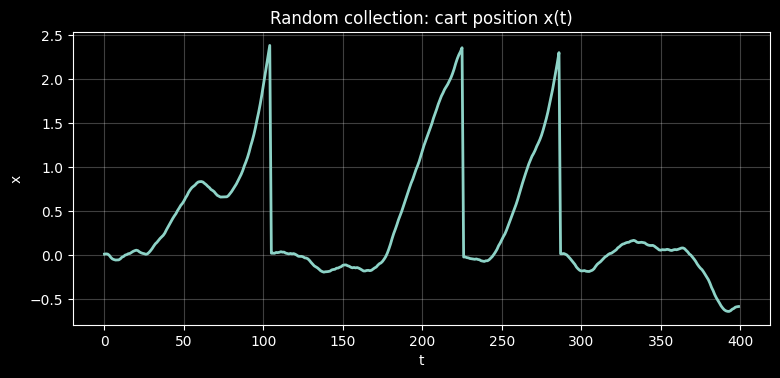

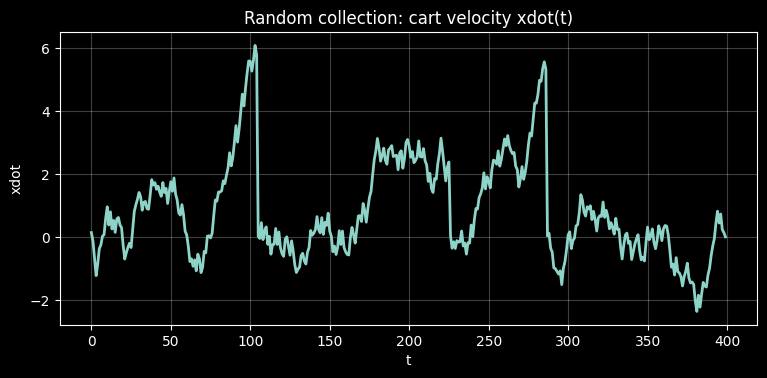

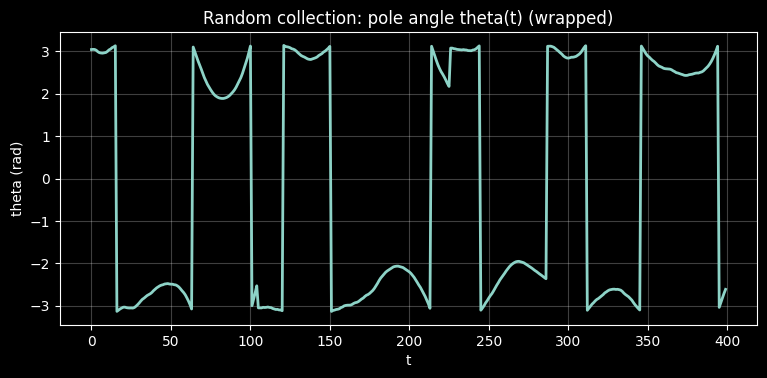

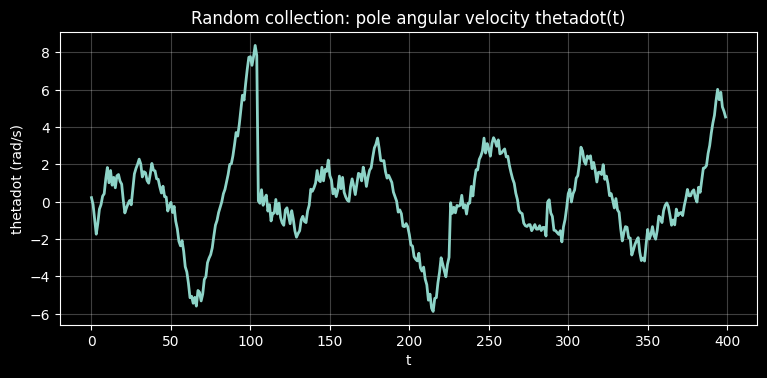

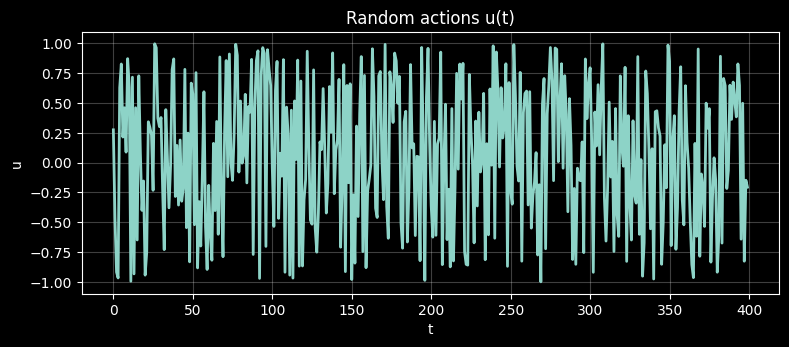

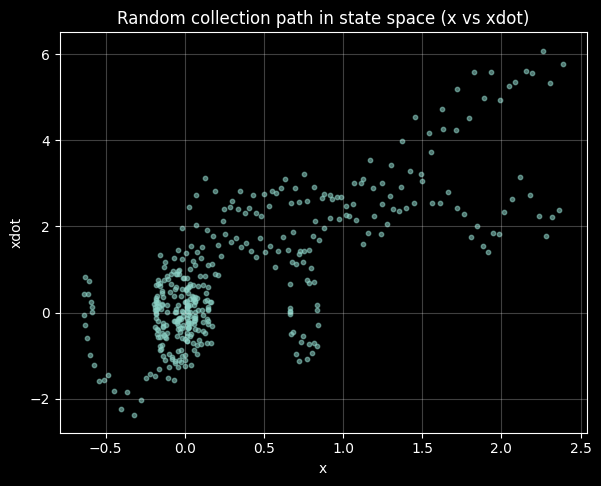

Collected X0 shape: (397, 6)  (6D features)
Targets shapes: (397, 1) (397, 1) (397, 1) (397, 1)
Kept=397  Dropped(respawn)=3  Resets=0


In [2]:
# ============================
# Cell 2 — Render the RANDOM collection path (and collect X,Y)  ✅ CartPole version
#
# Fix:
#   ✅ Adds render_cartpole_frame_from_state() (pure PIL) so the line:
#        frame = render_cartpole_frame_from_state(...)
#      actually works.
#
# What you get:
#   - Runs random actions for n_steps (with resets as needed)
#   - Collects executed transitions:
#       X0: (N,6)  = [x_feat, xdot_feat, sinθ, cosθ, w_feat, u]
#       Ydx0, Ydxdot0, Ydth0, Ydthdot0  (each (N,1))
#   - Records frames (rgb) and displays an inline animation (JS HTML)
#   - Plots trajectories:
#       x(t), xdot(t), theta(t), thetadot(t), action(t)
#       phase plot: x vs xdot
#
# IMPORTANT:
#   - We DO NOT rely on env.render() / pygame.
#   - We render from state using a self-contained PIL renderer below.
#   - If your env does edge respawn and sets info["respawned"]=True, we DROP that transition.
# ============================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import HTML, display

from PIL import Image, ImageDraw

# ------------------------------------------------------------
# Pure-PIL renderer: (x, theta) -> RGB frame
# ------------------------------------------------------------
def render_cartpole_frame_from_state(
    x, theta,
    x_threshold=2.4,
    W=720, H=450,
    cart_width=70,
    cart_height=35,
    pole_length_px=160,
    pole_width=10,
):
    """
    Minimal CartPole render (rgb uint8) from state.
    Coordinates:
      - x in [-x_threshold, x_threshold] maps to screen track
      - theta: 0 = upright, pi = down (standard)
    """
    # background
    img = Image.new("RGB", (W, H), (245, 245, 245))
    dr = ImageDraw.Draw(img)

    # track line
    y_track = int(0.72 * H)
    dr.line([(0, y_track), (W, y_track)], fill=(210, 210, 210), width=4)

    # map x -> screen px
    # keep margins so cart stays visible
    margin = 40
    x_clamped = float(np.clip(x, -x_threshold, x_threshold))
    x_norm = (x_clamped + x_threshold) / (2 * x_threshold)  # [0,1]
    cx = int(margin + x_norm * (W - 2 * margin))
    cy = y_track - cart_height // 2

    # cart rectangle
    x0 = cx - cart_width // 2
    y0 = cy - cart_height // 2
    x1 = cx + cart_width // 2
    y1 = cy + cart_height // 2
    dr.rounded_rectangle([x0, y0, x1, y1], radius=8, fill=(60, 90, 160), outline=(30, 30, 30), width=2)

    # axle point on top of cart
    ax = cx
    ay = y0 + 6

    # pole end point
    # IMPORTANT: theta=0 is upright -> pole points UP, so use -cos/sin appropriately
    # Standard cartpole uses theta from vertical; here we draw:
    #   dx =  L * sin(theta)
    #   dy = -L * cos(theta)
    dx = pole_length_px * float(np.sin(theta))
    dy = -pole_length_px * float(np.cos(theta))
    px = ax + dx
    py = ay + dy

    # pole (as thick line)
    dr.line([(ax, ay), (px, py)], fill=(180, 50, 50), width=pole_width)

    # axle circle
    r = 8
    dr.ellipse([ax - r, ay - r, ax + r, ay + r], fill=(30, 30, 30))

    return np.asarray(img, dtype=np.uint8)


# ------------------------------------------------------------
# Random collection (rendered)
# ------------------------------------------------------------
def collect_random_transitions_rendered_cartpole(
    n_steps=500,
    seed=0,
    max_episode_steps=500,
    start_down=True,
    # rendering controls
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    # edge-respawn handling (relies on your Cell 1 env.step() putting info["respawned"]=True)
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=True,
):
    rng = np.random.default_rng(seed)

    env_vis = make_env(
        render_mode=None,   # we render ourselves
        seed=seed,
        max_episode_steps=max_episode_steps,
        start_down=start_down,
        edge_respawn=edge_respawn,
        respawn_penalty=respawn_penalty,
    )

    obs, _ = env_vis.reset(seed=seed)
    x, xdot, th, thdot = obs_to_state(obs)

    frames = []
    traj = dict(
        x=[], xdot=[], theta=[], thetadot=[], u=[],
        kept=0, dropped_respawn=0, resets=0
    )

    X_list = []
    Ydx_list = []
    Ydxdot_list = []
    Ydth_list = []
    Ydthdot_list = []

    for t in range(n_steps):
        # sample random control
        u = float(rng.uniform(U_MIN, U_MAX))
        act = np.array([u], dtype=np.float32)

        # store previous state (s_t)
        x0, xdot0, th0, thdot0 = x, xdot, th, thdot

        obs1, r, terminated, truncated, info = env_vis.step(act)
        x1, xdot1, th1, thdot1 = obs_to_state(obs1)

        # if edge-respawn happened, optionally drop that transition
        respawned = bool(info.get("respawned", False))
        if respawned and drop_respawn_transitions:
            traj["dropped_respawn"] += 1
        else:
            # features from s_t and executed u
            feat = state_to_features(x0, xdot0, th0, thdot0, u).reshape(1, -1)

            # delta targets (s_{t+1} - s_t)
            # NOTE: theta is wrapped already in obs_to_state; this is consistent with your pipeline
            d_x = (x1 - x0)
            d_xdot = (xdot1 - xdot0)
            d_th = wrap_pi(th1 - th0)
            d_thdot = (thdot1 - thdot0)

            X_list.append(feat)
            Ydx_list.append([d_x])
            Ydxdot_list.append([d_xdot])
            Ydth_list.append([d_th])
            Ydthdot_list.append([d_thdot])

            traj["kept"] += 1

        # store trajectory for plots (always store executed path)
        traj["x"].append(x1)
        traj["xdot"].append(xdot1)
        traj["theta"].append(th1)
        traj["thetadot"].append(thdot1)
        traj["u"].append(u)

        # render occasionally
        if (t % frame_stride) == 0:
            frame = render_cartpole_frame_from_state(
                x1, th1,
                x_threshold=2.4,
                W=resize[0], H=resize[1],
            )
            frames.append(frame)

        # handle resets
        if terminated or truncated:
            traj["resets"] += 1
            obs, _ = env_vis.reset(seed=int(rng.integers(0, 10**9)))
            x, xdot, th, thdot = obs_to_state(obs)
        else:
            x, xdot, th, thdot = x1, xdot1, th1, thdot1

    env_vis.close()

    # stack outputs
    X0 = np.concatenate(X_list, axis=0).astype(np.float64)
    Ydx0 = np.asarray(Ydx_list, dtype=np.float64)
    Ydxdot0 = np.asarray(Ydxdot_list, dtype=np.float64)
    Ydth0 = np.asarray(Ydth_list, dtype=np.float64)
    Ydthdot0 = np.asarray(Ydthdot_list, dtype=np.float64)

    # ----------------------------
    # 1) animate frames
    # ----------------------------
    if len(frames) > 0:
        fig, ax = plt.subplots(figsize=(8, 5))
        im = ax.imshow(frames[0])
        ax.axis("off")

        def update(i):
            im.set_data(frames[i])
            return [im]

        ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000.0 / fps, blit=True)
        plt.close(fig)
        display(HTML(ani.to_jshtml()))
    else:
        print("⚠️ No frames collected (check frame_stride / resize).")

    # ----------------------------
    # 2) trajectory plots
    # ----------------------------
    tgrid = np.arange(len(traj["x"]))

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["x"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("x")
    plt.title("Random collection: cart position x(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["xdot"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("xdot")
    plt.title("Random collection: cart velocity xdot(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["theta"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("theta (rad)")
    plt.title("Random collection: pole angle theta(t) (wrapped)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.8))
    plt.plot(tgrid, traj["thetadot"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("thetadot (rad/s)")
    plt.title("Random collection: pole angular velocity thetadot(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(9, 3.4))
    plt.plot(tgrid, traj["u"], linewidth=2)
    plt.xlabel("t"); plt.ylabel("u")
    plt.title("Random actions u(t)")
    plt.grid(True, alpha=0.25); plt.show()

    plt.figure(figsize=(6.8, 5.2))
    plt.scatter(traj["x"], traj["xdot"], s=10, alpha=0.55)
    plt.xlabel("x"); plt.ylabel("xdot")
    plt.title("Random collection path in state space (x vs xdot)")
    plt.grid(True, alpha=0.25); plt.show()

    print("Collected X0 shape:", X0.shape, " (6D features)")
    print("Targets shapes:", Ydx0.shape, Ydxdot0.shape, Ydth0.shape, Ydthdot0.shape)
    print(f"Kept={traj['kept']}  Dropped(respawn)={traj['dropped_respawn']}  Resets={traj['resets']}")

    return X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames, traj


# ---- run it ----
SEED = 0
X0, Ydx0, Ydxdot0, Ydth0, Ydthdot0, frames0, traj0 = collect_random_transitions_rendered_cartpole(
    n_steps=400,
    seed=SEED,
    max_episode_steps=500,
    start_down=True,
    frame_stride=2,
    resize=(720, 450),
    fps=20,
    edge_respawn=True,
    respawn_penalty=-2.0,
    drop_respawn_transitions=True,
    verbose=False,
)

# Optional: quick distribution sanity
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Histogram(x=Ydth0.flatten(), nbinsx=60, name="Δtheta"))
fig.add_trace(go.Histogram(x=Ydthdot0.flatten(), nbinsx=60, name="Δthetadot"))
fig.update_layout(
    title="Initial random dataset: distribution of Δtheta and Δtheta_dot",
    barmode="overlay",
    xaxis_title="delta value",
    yaxis_title="count",
)
fig.update_traces(opacity=0.55)
fig.show()


In [3]:
# ===========================
# Cell 3 — OSGPR-VFE core (Streaming Sparse GP) + training + summaries + anchors
#
# Matches OUR pipeline:
#   - GLOBAL sparse GP lives on an inducing set Z (usually Z_GLOBAL, size M, capped)
#   - Each online update:
#       (a) extract old posterior summary at Z_old
#       (b) build a NEW OSGPR_VFE model on (X_new, Y_new) + old summary
#       (c) train a bit, then cache for fast prediction
#   - Anchors are selected FROM THE CURRENT inducing set Z (so you can reselect after updates)
#
# Provides:
#   - batch_state_to_features(): (B,4)+(B,) -> (B,6)
#   - OSGPR_VFE (single-output)
#   - train_osgpr()
#   - prior_summary(), extract_summary_from_model()
#   - greedy_dopt_anchors_from_K()
#   - rebuild_osgpr_from_old_summary(): returns (model_new, train_time, neg_obj)  ✅ fixes your unpack bug
# ===========================

import time
import copy
import numpy as np
import tensorflow as tf
import gpflow

from gpflow.inducing_variables import InducingPoints
from gpflow.models import GPModel, InternalDataTrainingLossMixin
from gpflow import covariances

# ---- numerics ----
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
tf.keras.backend.set_floatx("float64")

print("TF built with CUDA:", tf.test.is_built_with_cuda())
try:
    print("GPUs visible:", tf.config.list_physical_devices("GPU"))
except Exception as e:
    print("GPU query failed:", e)

DTYPE = gpflow.default_float()

# ---------------------------
# helpers
# ---------------------------
def sym_jitter(A, jitter=1e-6):
    """Make symmetric + add jitter (numpy)."""
    A = np.asarray(A, dtype=np.float64)
    A = 0.5 * (A + A.T)
    A = A + float(jitter) * np.eye(A.shape[0], dtype=np.float64)
    return A

def finite_mask(*arrs):
    """Row-wise finite mask across arrays."""
    m = None
    for a in arrs:
        a = np.asarray(a)
        mm = np.isfinite(a).all(axis=1) if a.ndim == 2 else np.isfinite(a)
        m = mm if m is None else (m & mm)
    return m

def clone_kernel(kernel):
    """
    Clone a GPflow kernel (to avoid variable-sharing across models).
    gpflow.utilities.deepcopy exists in many versions; fallback to copy.deepcopy.
    """
    try:
        from gpflow.utilities import deepcopy as gf_deepcopy
        return gf_deepcopy(kernel)
    except Exception:
        return copy.deepcopy(kernel)

# ------------------------------------------------------------
# Batch feature map (FAST) — used by MPPI later
# ------------------------------------------------------------
def batch_state_to_features(S, U, x_scale=2.4, v_scale=3.0, w_scale=8.0):
    """
    Vectorized mapping from physical CartPole state to 6D GP features.

    S: (B,4)  [x, xdot, theta, thetadot]
    U: (B,)   action in [-1,1]
    Returns:
      Xfeat: (B,6) [tanh(x/xs), tanh(xdot/vs), sin(theta), cos(theta), tanh(thetadot/ws), u]
    """
    S = np.asarray(S, dtype=np.float64)
    U = np.asarray(U, dtype=np.float64).reshape(-1)
    assert S.ndim == 2 and S.shape[1] == 4, "S must be (B,4)"
    assert U.shape[0] == S.shape[0], "U must match batch size"

    x     = S[:, 0]
    xdot  = S[:, 1]
    th    = S[:, 2]
    thdot = S[:, 3]

    Xf = np.empty((S.shape[0], 6), dtype=np.float64)
    Xf[:, 0] = np.tanh(x / x_scale)
    Xf[:, 1] = np.tanh(xdot / v_scale)
    Xf[:, 2] = np.sin(th)
    Xf[:, 3] = np.cos(th)
    Xf[:, 4] = np.tanh(thdot / w_scale)
    Xf[:, 5] = U
    return Xf

# ============================================================
# OSGPR-VFE model — regression-only, single-output
# ============================================================
class OSGPR_VFE(GPModel, InternalDataTrainingLossMixin):
    """
    Online Sparse Variational GP Regression (VFE), SINGLE-OUTPUT.

    Provide:
      - current batch data (X, Y)
      - old summary q_old(u)=N(mu_old, Su_old) at Z_old
      - Kaa_old = K(Z_old,Z_old) from old step
      - new inducing Z (usually Z_GLOBAL; you MAY refresh Z over time, but size should be capped)

    Includes:
      - predict_f (correct but slower)
      - build_predict_cache + predict_f_cached (FAST diag predictions)
    """
    def __init__(self, data, kernel, mu_old, Su_old, Kaa_old, Z_old, Z, mean_function=None):
        X, Y = gpflow.models.util.data_input_to_tensor(data)
        self.X, self.Y = X, Y

        likelihood = gpflow.likelihoods.Gaussian()
        num_latent_gps = GPModel.calc_num_latent_gps_from_data(data, kernel, likelihood)
        super().__init__(kernel, likelihood, mean_function, num_latent_gps)

        Z = np.asarray(Z, dtype=np.float64)
        assert Z.ndim == 2, "Z must be (M, D)"
        self.inducing_variable = InducingPoints(Z)
        gpflow.set_trainable(self.inducing_variable, False)
        mu_old  = np.asarray(mu_old, dtype=np.float64).reshape(-1, 1)
        Su_old  = sym_jitter(Su_old, 1e-6)
        Kaa_old = sym_jitter(Kaa_old, 1e-6)
        Z_old   = np.asarray(Z_old, dtype=np.float64)

        self.mu_old  = tf.Variable(mu_old,  trainable=False, dtype=DTYPE)
        self.Su_old  = tf.Variable(Su_old,  trainable=False, dtype=DTYPE)
        self.Kaa_old = tf.Variable(Kaa_old, trainable=False, dtype=DTYPE)
        self.Z_old   = tf.Variable(Z_old,   trainable=False, dtype=DTYPE)

        if self.mean_function is None:
            self.mean_function = gpflow.mean_functions.Zero()

        # cache for fast predict
        self._cache_ready = False
        self._cache_Lb = None
        self._cache_LD = None
        self._cache_rhs = None

    def _common_terms(self):
        """
        Build common matrices used by both ELBO and prediction.

        Z   : new inducing (Mb)
        Za  : old inducing (Ma) == self.Z_old
        X   : current batch inputs

        Kbf = K(Z, X)    [Mb, N]
        Kbb = K(Z, Z)    [Mb, Mb]
        Kba = K(Z, Za)   [Mb, Ma]
        """
        jitter = gpflow.utilities.to_default_float(1e-6)
        sigma2 = self.likelihood.variance

        Saa = self.Su_old  # [Ma,Ma]
        ma  = self.mu_old  # [Ma,1]

        Kbf = covariances.Kuf(self.inducing_variable, self.kernel, self.X)           # [Mb, N]
        Kbb = covariances.Kuu(self.inducing_variable, self.kernel, jitter=jitter)   # [Mb, Mb]
        Kba = covariances.Kuf(self.inducing_variable, self.kernel, self.Z_old)      # [Mb, Ma]

        Kaa_cur = gpflow.utilities.add_noise_cov(self.kernel(self.Z_old), jitter)   # [Ma,Ma]
        Kaa     = gpflow.utilities.add_noise_cov(self.Kaa_old, jitter)              # [Ma,Ma]

        err = self.Y - self.mean_function(self.X)  # [N,1]

        # c = Kbf*(Y/sigma2) + Kba*(Saa^{-1} ma)
        Sainv_ma = tf.linalg.solve(Saa, ma)                                # [Ma,1]
        c = tf.matmul(Kbf, self.Y / sigma2) + tf.matmul(Kba, Sainv_ma)     # [Mb,1]

        # Cholesky(Kbb)
        Lb = tf.linalg.cholesky(Kbb)                                       # [Mb,Mb]
        Lbinv_c   = tf.linalg.triangular_solve(Lb, c,   lower=True)        # [Mb,1]
        Lbinv_Kba = tf.linalg.triangular_solve(Lb, Kba, lower=True)        # [Mb,Ma]
        Lbinv_Kbf = tf.linalg.triangular_solve(Lb, Kbf, lower=True) / tf.sqrt(sigma2)  # [Mb,N]

        d1 = tf.matmul(Lbinv_Kbf, Lbinv_Kbf, transpose_b=True)             # [Mb,Mb]

        # T = (Lb^{-1}Kba)^T  => [Ma,Mb]
        T = tf.linalg.matrix_transpose(Lbinv_Kba)

        # d2
        LSa = tf.linalg.cholesky(Saa)
        LSainv_T = tf.linalg.triangular_solve(LSa, T, lower=True)
        d2 = tf.matmul(LSainv_T, LSainv_T, transpose_a=True)               # [Mb,Mb]

        # d3
        La = tf.linalg.cholesky(Kaa)
        Lainv_T = tf.linalg.triangular_solve(La, T, lower=True)
        d3 = tf.matmul(Lainv_T, Lainv_T, transpose_a=True)                 # [Mb,Mb]

        Mb = self.inducing_variable.num_inducing
        D = tf.eye(Mb, dtype=DTYPE) + d1 + d2 - d3
        D = gpflow.utilities.add_noise_cov(D, jitter)
        LD = tf.linalg.cholesky(D)

        rhs = tf.linalg.triangular_solve(LD, Lbinv_c, lower=True)          # [Mb,1]

        Qff_diag = tf.reduce_sum(tf.square(Lbinv_Kbf), axis=0)             # [N]

        tf.debugging.assert_all_finite(Lb,  "Lb has NaN/Inf")
        tf.debugging.assert_all_finite(LD,  "LD has NaN/Inf")
        tf.debugging.assert_all_finite(rhs, "rhs has NaN/Inf")

        return (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD, Lbinv_Kba, rhs, err, Qff_diag)

    def maximum_log_likelihood_objective(self):
        sigma2 = self.likelihood.variance
        N = tf.cast(tf.shape(self.X)[0], DTYPE)

        Saa = self.Su_old
        ma  = self.mu_old
        Kfdiag = self.kernel(self.X, full_cov=False)

        (Kbf, Kba, Kaa, Kaa_cur, La, Kbb, Lb, D, LD,
         Lbinv_Kba, rhs, err, Qff_diag) = self._common_terms()

        LSa = tf.linalg.cholesky(Saa)
        Lainv_ma = tf.linalg.triangular_solve(LSa, ma, lower=True)

        bound = -0.5 * N * np.log(2.0 * np.pi)
        bound += -0.5 * tf.reduce_sum(tf.square(err)) / sigma2
        bound += -0.5 * tf.reduce_sum(tf.square(Lainv_ma))
        bound +=  0.5 * tf.reduce_sum(tf.square(rhs))

        bound += -0.5 * N * tf.math.log(sigma2)
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LD)))

        bound += -0.5 * tf.reduce_sum(Kfdiag) / sigma2
        bound +=  0.5 * tf.reduce_sum(Qff_diag)

        bound += tf.reduce_sum(tf.math.log(tf.linalg.diag_part(La)))
        bound += -tf.reduce_sum(tf.math.log(tf.linalg.diag_part(LSa)))

        # correction term involving Kaa_cur - Qaa
        Kaadiff = Kaa_cur - tf.matmul(Lbinv_Kba, Lbinv_Kba, transpose_a=True)
        Sainv_Kaadiff = tf.linalg.solve(Saa, Kaadiff)
        Kainv_Kaadiff = tf.linalg.solve(Kaa, Kaadiff)

        bound += -0.5 * tf.reduce_sum(
            tf.linalg.diag_part(Sainv_Kaadiff) - tf.linalg.diag_part(Kainv_Kaadiff)
        )
        return bound

    def predict_f(self, Xnew, full_cov=False):
        jitter = gpflow.utilities.to_default_float(1e-6)

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [Mb, Nnew]
        (_, _, _, _, _, _, Lb, _, LD, _, rhs, _, _) = self._common_terms()

        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)  # [Nnew,1]

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=DTYPE)
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

    def build_predict_cache(self):
        """Build cached matrices for fast predict_f_cached(). Call after training / after each update."""
        (_, _, _, _, _, _, Lb, _, LD, _, rhs, _, _) = self._common_terms()
        self._cache_Lb = Lb
        self._cache_LD = LD
        self._cache_rhs = rhs
        self._cache_ready = True

    def predict_f_cached(self, Xnew, full_cov=False):
        """Fast diag prediction using cached Lb, LD, rhs."""
        if not self._cache_ready:
            return self.predict_f(Xnew, full_cov=full_cov)

        jitter = gpflow.utilities.to_default_float(1e-6)
        Lb  = self._cache_Lb
        LD  = self._cache_LD
        rhs = self._cache_rhs

        Kbs = covariances.Kuf(self.inducing_variable, self.kernel, Xnew)  # [Mb,Nnew]
        Lbinv_Kbs = tf.linalg.triangular_solve(Lb, Kbs, lower=True)
        LDinv_Lbinv_Kbs = tf.linalg.triangular_solve(LD, Lbinv_Kbs, lower=True)
        mean = tf.matmul(LDinv_Lbinv_Kbs, rhs, transpose_a=True)

        if full_cov:
            Kss = self.kernel(Xnew) + jitter * tf.eye(tf.shape(Xnew)[0], dtype=DTYPE)
            var = (
                Kss
                - tf.matmul(Lbinv_Kbs, Lbinv_Kbs, transpose_a=True)
                + tf.matmul(LDinv_Lbinv_Kbs, LDinv_Lbinv_Kbs, transpose_a=True)
            )
            return mean + self.mean_function(Xnew), var
        else:
            var = (
                self.kernel(Xnew, full_cov=False)
                - tf.reduce_sum(tf.square(Lbinv_Kbs), axis=0)
                + tf.reduce_sum(tf.square(LDinv_Lbinv_Kbs), axis=0)
            )
            var = tf.maximum(var, tf.cast(1e-12, var.dtype))
            return mean + self.mean_function(Xnew), var

# ----------------------------
# training helper
# ----------------------------
def train_osgpr(model, iters=250, lr=0.02, clip_norm=10.0, compile_step=True):
    """Adam optimize the negative ELBO."""
    opt = tf.keras.optimizers.Adam(lr)

    def step_impl():
        with tf.GradientTape() as tape:
            loss = -model.maximum_log_likelihood_objective()
        grads = tape.gradient(loss, model.trainable_variables)
        if clip_norm is not None:
            grads = [tf.clip_by_norm(g, clip_norm) if g is not None else None for g in grads]
        opt.apply_gradients([(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None])
        return loss

    step = tf.function(step_impl) if compile_step else step_impl

    t0 = time.time()
    last = None
    for _ in range(int(iters)):
        last = step()
    return float(time.time() - t0), float(last.numpy())
# ----------------------------
# summaries (to chain online)
# ----------------------------
def prior_summary(kernel, Z):
    """
    Prior summary at inducing Z for the first model:
      mu0 = 0
      Su0 = Kzz
      Kaa0 = Kzz
    """
    Z = np.asarray(Z, dtype=np.float64)
    Kzz = kernel.K(Z).numpy()
    Kzz = sym_jitter(Kzz, 1e-6)
    mu0 = np.zeros((Z.shape[0], 1), dtype=np.float64)
    return mu0, Kzz, Kzz, Z

def extract_summary_from_model(model):
    """
    Extract q(u)=N(mu,Su) at model's current inducing Z plus Kaa=K(Z,Z).
    """
    Z = model.inducing_variable.Z.numpy().astype(np.float64)

    mu_tf, Sig_tf = model.predict_f(Z, full_cov=True)
    mu = mu_tf.numpy().reshape(-1, 1)

    Su = Sig_tf.numpy()
    if Su.ndim == 3:
        Su = Su[0]
    Su = sym_jitter(Su, 1e-6)

    Kaa = model.kernel.K(Z).numpy()
    Kaa = sym_jitter(Kaa, 1e-6)
    return mu, Su, Kaa, Z

# ============================================================
# Anchors: greedy D-opt (log-det) on Kzz
# ============================================================
def greedy_dopt_anchors_from_K(Kzz, m_anchors=24, lam=1e-6):
    """
    Greedy log-det anchor selection on PSD Kzz using incremental Cholesky updates.
    Returns indices of size m_anchors.
    """
    K = np.asarray(Kzz, dtype=np.float64)
    M = K.shape[0]
    assert K.shape == (M, M)
    K = sym_jitter(K, lam)

    chosen = []
    diag = np.clip(np.diag(K).copy(), 1e-12, None)
    remaining = np.ones(M, dtype=bool)
    L = None

    for k in range(min(int(m_anchors), M)):
        if k == 0:
            i = int(np.argmax(diag))
            chosen.append(i)
            remaining[i] = False
            L = np.array([[np.sqrt(diag[i])]], dtype=np.float64)
            continue

        S = np.array(chosen, dtype=np.int64)
        Ks_all = K[np.ix_(S, np.arange(M))]     # (k,M)

        v = np.linalg.solve(L, Ks_all)          # (k,M)
        vn2 = np.sum(v * v, axis=0)             # (M,)
        s2 = diag - vn2
        s2 = np.where(remaining, s2, -np.inf)

        i = int(np.argmax(s2))
        if not np.isfinite(s2[i]) or s2[i] <= 1e-12:
            cand = np.where(remaining)[0]
            if len(cand) == 0:
                break
            i = int(cand[np.argmax(diag[cand])])
            s2_i = max(diag[i], 1e-12)
        else:
            s2_i = float(s2[i])

        chosen.append(i)
        remaining[i] = False

        kvec = K[np.ix_(S, [i])].reshape(-1, 1)  # (k,1)
        w = np.linalg.solve(L, kvec)             # (k,1)
        alpha = np.sqrt(max(s2_i, 1e-12))

        L_new = np.zeros((k + 1, k + 1), dtype=np.float64)
        L_new[:k, :k] = L
        L_new[k, :k] = w.reshape(-1)
        L_new[k, k] = alpha
        L = L_new

    return np.array(chosen, dtype=np.int64)

# ============================================================
# Online update builder (GLOBAL update step)
# ============================================================
def rebuild_osgpr_from_old_summary(
    model_old,
    X_new,
    Y_new,
    Z_new=None,
    iters=120,
    lr=0.02,
    noise=1e-4,
    freeze_kernel=False,
    clip_norm=10.0,
):
    """
    Build a NEW OSGPR_VFE model using:
      - old posterior summary extracted from model_old at its inducing Z_old
      - new executed batch (X_new, Y_new)
      - inducing set Z_new (defaults to model_old.Z; you may pass a refreshed Z here)

    Returns:
      model_new, train_time_sec, last_neg_obj
    """
    # old summary
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)

    # inducing set for the new model
    if Z_new is None:
        Z_use = Z_old
    else:
        Z_use = np.asarray(Z_new, dtype=np.float64)

    # clone kernel to avoid variable-sharing surprises
    k_new = clone_kernel(model_old.kernel)

    m = OSGPR_VFE(
        data=(np.asarray(X_new, dtype=np.float64), np.asarray(Y_new, dtype=np.float64)),
        kernel=k_new,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=Z_use,
    )
    m.likelihood.variance.assign(float(noise))

    if freeze_kernel:
        try:
            m.kernel.variance.trainable = False
            m.kernel.lengthscales.trainable = False
        except Exception:
            pass

    t_sec, neg = train_osgpr(m, iters=iters, lr=lr, clip_norm=clip_norm)
    m.build_predict_cache()
    return m, float(t_sec), float(neg)

print("✅ OSGPR core + helpers ready (Cell 3 aligned to pipeline)")


TF built with CUDA: True
GPUs visible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ OSGPR core + helpers ready (Cell 3 aligned to pipeline)


In [4]:
# ===========================
# Cell 4 — MPPI (TF/GPU) planner + GP dynamics rollout + corridor utilities
#
# What this cell provides (definitions only; run loops are in Cells 6/7/8):
#   - tf_feature_map(): state/action -> 6D features (float64)
#   - DiagSparsePosteriorPack: fast local/global predictor pack (mean + diag var)
#   - build_pack_from_model(): build pack from a GP model at chosen inducing Z_sub
#   - predict_pack_mu_var_tf(): TF prediction using pack (fast; no full_cov)
#   - mppi_build_planner_tf(): compiles a tf.function MPPI planner (returns u0,u_mean_new,tubeX,unc_w,r2,inv_var,corr_dbg)
#   - corridor_min_dist_tf(): min whitened distance from Xpool to nominal tube features
#   - kcenter_farthest_first(): numpy k-center selection utility (used later in PALSGP Cell 6)
#   - is_success_state(): success predicate (used in run loops)
#
# Notes:
#   - All TF/GP compute uses float64.
#   - Dynamics are modeled as DELTAS: s_{t+1} = s_t + Δs
#   - Theta is wrapped each step using atan2(sin,cos).
# ===========================

import numpy as np
import tensorflow as tf
import gpflow
import time

DTF = tf.float64

# ------------------------------------------------------------
# TF feature map: state (x,xdot,th,thdot) + action u -> (6,)
# ------------------------------------------------------------
@tf.function
def tf_feature_map(s, u, x_scale=2.4, v_scale=3.0, w_scale=8.0):
    """
    s: (...,4) float64
    u: (...,)  float64
    returns: (...,6) float64
    """
    x     = s[..., 0]
    xdot  = s[..., 1]
    th    = s[..., 2]
    thdot = s[..., 3]

    f0 = tf.tanh(x / x_scale)
    f1 = tf.tanh(xdot / v_scale)
    f2 = tf.sin(th)
    f3 = tf.cos(th)
    f4 = tf.tanh(thdot / w_scale)
    f5 = u

    return tf.stack([f0, f1, f2, f3, f4, f5], axis=-1)

@tf.function
def tf_wrap_angle(th):
    return tf.atan2(tf.sin(th), tf.cos(th))

# ------------------------------------------------------------
# Success predicate (for CartPole swing-up)
# ------------------------------------------------------------
def is_success_state(x, xdot, th, thdot,
                     cos_th_min=0.98, x_abs_max=0.35, xdot_abs_max=1.0, thdot_abs_max=2.5):
    """
    A simple swing-up success check. Tune thresholds if needed.
    """
    return (np.cos(th) >= cos_th_min) and (abs(x) <= x_abs_max) and (abs(xdot) <= xdot_abs_max) and (abs(thdot) <= thdot_abs_max)

# ------------------------------------------------------------
# Diagonal posterior inducing pack (fast predictor)
# ------------------------------------------------------------
class DiagSparsePosteriorPack:
    """
    Stores everything needed for fast predictive mean/diag-var:
      Kzz = chol(L)
      m_w = L^{-1} mu_u
      C_T = (L^{-1} diag(sqrt(Su_diag)))^T   (so we can compute var_add cheaply)

    Prediction for f(x):
      A = L^{-1} Kzx
      mean = A^T m_w
      var  = kxx - sum(A^2) + sum((C_T @ A)^2)   (diag posterior approx)
    """
    __slots__ = ("Z", "L", "m_w", "C_T", "lik_var")

    def __init__(self, Z, L, m_w, C_T, lik_var):
        self.Z = Z
        self.L = L
        self.m_w = m_w
        self.C_T = C_T
        self.lik_var = lik_var

def build_pack_from_model(model, Z_sub, jitter=1e-6, use_cached=True):
    """
    Build DiagSparsePosteriorPack from a GP model at inducing points Z_sub.
    We approximate Su as diag(var(f(Z_sub))).
    """
    Z_sub = np.asarray(Z_sub, dtype=np.float64)
    Zt = tf.convert_to_tensor(Z_sub, dtype=DTF)

    # posterior at Z_sub (diag only)
    if use_cached and hasattr(model, "predict_f_cached"):
        mu_tf, var_tf = model.predict_f_cached(Zt, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(Zt, full_cov=False)

    mu = tf.reshape(mu_tf, (-1, 1))                      # (M,1)
    Su_diag = tf.reshape(var_tf, (-1,))                  # (M,)
    Su_diag = tf.maximum(Su_diag, tf.constant(1e-12, DTF))

    # Kzz
    Kzz = model.kernel(Zt)                               # (M,M)
    Kzz = 0.5 * (Kzz + tf.transpose(Kzz))
    Kzz = Kzz + tf.constant(float(jitter), DTF) * tf.eye(tf.shape(Zt)[0], dtype=DTF)
    L = tf.linalg.cholesky(Kzz)

    # m_w = L^{-1} mu
    m_w = tf.linalg.triangular_solve(L, mu, lower=True)

    # C = L^{-1} diag(sqrt(Su_diag))
    # compute Linv once (M,M) and scale columns
    I = tf.eye(tf.shape(Zt)[0], dtype=DTF)
    Linv = tf.linalg.triangular_solve(L, I, lower=True)  # L^{-1}
    sqrt_s = tf.sqrt(Su_diag)
    C = Linv * tf.reshape(sqrt_s, (1, -1))               # scale columns
    C_T = tf.transpose(C)

    try:
        lik_var = float(model.likelihood.variance.numpy())
    except Exception:
        lik_var = 0.0

    return DiagSparsePosteriorPack(
        Z=Zt, L=L, m_w=m_w, C_T=C_T, lik_var=tf.constant(lik_var, dtype=DTF)
    )

# ------------------------------------------------------------
# TF prediction using a pack (mean + diag-var)
# ------------------------------------------------------------
@tf.function
def predict_pack_mu_var_tf(pack_Z, pack_L, pack_mw, pack_CT, lik_var, kernel, Xfeat):
    """
    Xfeat: (B,6)
    returns:
      mu:  (B,)
      var: (B,)  (latent f variance; does NOT include likelihood unless you add it)
    """
    # Kzx: (M,B)
    Kzx = kernel(pack_Z, Xfeat)          # (M,B)
    A = tf.linalg.triangular_solve(pack_L, Kzx, lower=True)   # (M,B)

    mu = tf.matmul(A, pack_mw, transpose_a=True)             # (B,1)
    mu = tf.reshape(mu, (-1,))

    kxx = kernel(Xfeat, full_cov=False)                      # (B,)
    q = tf.reduce_sum(tf.square(A), axis=0)                  # (B,)

    # var_add = sum((C_T @ A)^2)
    E = tf.matmul(pack_CT, A)                                # (M,B)
    var_add = tf.reduce_sum(tf.square(E), axis=0)            # (B,)

    var = kxx - q + var_add
    var = tf.maximum(var, tf.constant(1e-12, DTF))
    return mu, var

# ------------------------------------------------------------
# Corridor distance: min whitened squared distance from pool to tube
# ------------------------------------------------------------
@tf.function
def corridor_min_dist_tf(Xpool, tubeX, inv_var, softmin_temp=20.0):
    """
    Xpool : (N,6)
    tubeX : (H,6)
    inv_var: (6,) whitening weights (e.g., 1/(var+eps))
    Returns:
      r2_min: (N,) min_h sum_d inv_var[d]*(Xpool - tubeX[h])^2
    """
    # (N,H,6)
    diff = tf.expand_dims(Xpool, 1) - tf.expand_dims(tubeX, 0)
    wdiff2 = tf.square(diff) * tf.reshape(inv_var, (1, 1, -1))
    d2 = tf.reduce_sum(wdiff2, axis=-1)  # (N,H)

    # hard min
    r2_min = tf.reduce_min(d2, axis=1)

    return r2_min

# ------------------------------------------------------------
# MPPI cost function (tunable weights)
# ------------------------------------------------------------
@tf.function
def stage_cost_tf(s, u,
                  w_theta=8.0, w_x=0.8, w_xdot=0.08, w_thdot=0.08, w_u=0.02):
    """
    s: (K,4) or (...,4)
    u: (K,)  or (...,)
    cost ~ (1-cos(theta)) + penalties
    """
    x     = s[..., 0]
    xdot  = s[..., 1]
    th    = s[..., 2]
    thdot = s[..., 3]

    c = (w_theta * (1.0 - tf.cos(th))
         + w_x * tf.square(x)
         + w_xdot * tf.square(xdot)
         + w_thdot * tf.square(thdot)
         + w_u * tf.square(u))
    return c

# ------------------------------------------------------------
# One GP dynamics step for a batch (K rollouts) using 4 packs
# ------------------------------------------------------------
@tf.function
def gp_step_batch_tf(s, u,
                     pack_dx, pack_dxdot, pack_dth, pack_dthdot,
                     k_dx, k_dxdot, k_dth, k_dthdot,
                     unc_lambda=0.0):
    """
    s: (K,4), u: (K,)
    Returns:
      s_next: (K,4)
      unc_bonus: (K,)  (optional uncertainty penalty term)
      unc_scalar: (K,) scalar uncertainty proxy (for logging)
    """
    Xfeat = tf_feature_map(s, u)  # (K,6)

    mu_dx,  var_dx  = predict_pack_mu_var_tf(pack_dx.Z,     pack_dx.L,     pack_dx.m_w,     pack_dx.C_T,     pack_dx.lik_var,     k_dx,     Xfeat)
    mu_dxd, var_dxd = predict_pack_mu_var_tf(pack_dxdot.Z,  pack_dxdot.L,  pack_dxdot.m_w,  pack_dxdot.C_T,  pack_dxdot.lik_var,  k_dxdot,  Xfeat)
    mu_dt,  var_dt  = predict_pack_mu_var_tf(pack_dth.Z,    pack_dth.L,    pack_dth.m_w,    pack_dth.C_T,    pack_dth.lik_var,    k_dth,    Xfeat)
    mu_dtd, var_dtd = predict_pack_mu_var_tf(pack_dthdot.Z, pack_dthdot.L, pack_dthdot.m_w, pack_dthdot.C_T, pack_dthdot.lik_var, k_dthdot, Xfeat)

    # state update with DELTAS
    x     = s[:, 0] + mu_dx
    xdot  = s[:, 1] + mu_dxd
    th    = tf_wrap_angle(s[:, 2] + mu_dt)
    thdot = s[:, 3] + mu_dtd

    s_next = tf.stack([x, xdot, th, thdot], axis=-1)

    # scalar uncertainty proxy (use dxdot head; include likelihood variance)
    unc = tf.sqrt(tf.maximum(var_dxd + pack_dxdot.lik_var, tf.constant(1e-12, DTF)))

    unc_bonus = unc_lambda * unc
    return s_next, unc_bonus, unc

# ------------------------------------------------------------
# Build a compiled MPPI planner (tf.function)
# ------------------------------------------------------------
def mppi_build_planner_tf(
    k_dx, k_dxdot, k_dth, k_dthdot,
    H=25, K=4096,
    sigma=0.35,
    lam=1.0,
    u_min=-1.0, u_max=1.0,
    unc_lambda=0.0,
    tube_invvar_eps=1e-4,
):
    """
    Returns a tf.function:
      plan_tf(s0, u_mean, pack_dx, pack_dxdot, pack_dth, pack_dthdot, Xpool, corr_r0, corr_r1)
        -> u0, u_mean_new, tubeX, unc_w, r2_pool, inv_var, corr_dbg

    Inputs:
      s0      : (4,) float64
      u_mean  : (H,) float64
      packs   : DiagSparsePosteriorPack (python objects; captured by closure)
      Xpool   : (N,6) float64 or empty (0,6)
      corr_r0 : float (threshold for "core" corridor)
      corr_r1 : float (threshold for "expanded" corridor)

    Notes:
      - Corridor outputs are optional (if Xpool is empty, returns empty r2_pool).
      - tubeX is computed from nominal rollout (using u_mean, mean dynamics).
    """

    sigma = float(sigma)
    lam = float(lam)
    u_min = float(u_min)
    u_max = float(u_max)

    @tf.function
    def plan_tf(s0, u_mean,
                pack_dx, pack_dxdot, pack_dth, pack_dthdot,
                Xpool, corr_r0, corr_r1):
        s0 = tf.cast(tf.reshape(s0, (4,)), DTF)
        u_mean = tf.cast(tf.reshape(u_mean, (H,)), DTF)

        # Sample controls: U = clip(u_mean + eps)
        eps = tf.random.normal(shape=(K, H), mean=0.0, stddev=sigma, dtype=DTF)
        U = tf.clip_by_value(tf.expand_dims(u_mean, 0) + eps, u_min, u_max)  # (K,H)

        # Rollout trajectories & costs
        s = tf.repeat(tf.expand_dims(s0, 0), repeats=K, axis=0)  # (K,4)
        cost = tf.zeros((K,), dtype=DTF)

        # for logging: average uncertainty over horizon
        unc_sum = tf.zeros((K,), dtype=DTF)

        for t in tf.range(H):
            u_t = U[:, t]
            s, unc_bonus, unc = gp_step_batch_tf(
                s, u_t,
                pack_dx, pack_dxdot, pack_dth, pack_dthdot,
                k_dx, k_dxdot, k_dth, k_dthdot,
                unc_lambda=tf.constant(unc_lambda, DTF),
            )
            c_t = stage_cost_tf(s, u_t)
            cost = cost + c_t + unc_bonus
            unc_sum = unc_sum + unc

        # MPPI weights
        beta = tf.reduce_min(cost)
        w = tf.exp(-(cost - beta) / tf.constant(lam, DTF))
        w_sum = tf.reduce_sum(w) + tf.constant(1e-12, DTF)

        # update mean controls
        U_weighted = tf.reduce_sum(tf.expand_dims(w, 1) * U, axis=0) / w_sum  # (H,)
        u_mean_new = U_weighted

        # first control to execute
        u0 = u_mean_new[0]

        # uncertainty summary (for logging)
        unc_w = tf.reduce_sum(w * (unc_sum / tf.cast(H, DTF))) / w_sum

        # ---- nominal tube rollout for corridor ----
        sT = tf.reshape(s0, (1, 4))
        tubeX_list = []
        for t in tf.range(H):
            u_t = tf.reshape(u_mean_new[t], (1,))
            Xft = tf_feature_map(sT, u_t)          # (1,6)
            tubeX_list.append(tf.reshape(Xft, (6,)))
            sT, _, _ = gp_step_batch_tf(
                sT, u_t,
                pack_dx, pack_dxdot, pack_dth, pack_dthdot,
                k_dx, k_dxdot, k_dth, k_dthdot,
                unc_lambda=tf.constant(0.0, DTF),   # nominal tube shouldn't include penalty
            )
        tubeX = tf.stack(tubeX_list, axis=0)       # (H,6)

        # whitening weights based on tube feature variance
        tube_var = tf.math.reduce_variance(tubeX, axis=0)
        inv_var = 1.0 / (tube_var + tf.constant(tube_invvar_eps, DTF))      # (6,)

        # corridor distances for a candidate pool (if provided)
        Npool = tf.shape(Xpool)[0]
        r2_pool = tf.cond(
            Npool > 0,
            lambda: corridor_min_dist_tf(Xpool, tubeX, inv_var),
            lambda: tf.zeros((0,), dtype=DTF),
        )

        # corridor debug / counts
        inside0 = tf.reduce_sum(tf.cast(r2_pool <= corr_r0, tf.int32))
        inside1 = tf.reduce_sum(tf.cast(r2_pool <= corr_r1, tf.int32))

        corr_dbg = tf.stack([
            tf.cast(Npool, tf.float64),
            tf.cast(inside0, tf.float64),
            tf.cast(inside1, tf.float64),
        ], axis=0)  # [Npool, inside0, inside1]

        return u0, u_mean_new, tubeX, unc_w, r2_pool, inv_var, corr_dbg

    return plan_tf

# ------------------------------------------------------------
# Numpy k-center / farthest-first (used later in PALSGP)
# ------------------------------------------------------------
def kcenter_farthest_first(X, m, start_idx=0):
    """
    Classic farthest-first traversal (k-center) on X (N,D).
    Returns selected indices length <= m.
    """
    X = np.asarray(X, dtype=np.float64)
    N = X.shape[0]
    if N == 0 or m <= 0:
        return np.array([], dtype=np.int64)
    m = min(int(m), N)

    sel = np.empty((m,), dtype=np.int64)
    sel[0] = int(np.clip(start_idx, 0, N - 1))

    # initialize min distances to first center
    d2 = np.sum((X - X[sel[0]])**2, axis=1)

    for k in range(1, m):
        i = int(np.argmax(d2))
        sel[k] = i
        d2_new = np.sum((X - X[i])**2, axis=1)
        d2 = np.minimum(d2, d2_new)

    return sel

print("✅ Cell 4 ready: MPPI + packs + corridor utilities")


✅ Cell 4 ready: MPPI + packs + corridor utilities


In [5]:
# ===========================
# Cell 5 — Experiment config + Eval metrics + Registry helpers
#
# Purpose:
#   - Define global knobs shared by ALL methods (PALSGP / OSGPR_GLOBAL / SVGP_GLOBAL)
#   - Define richer evaluation metrics you asked for
#   - Provide a consistent EVAL_REGISTRY schema used by Cell 9 plotting
#
# Notes:
#   - Env obs/action can stay float32; GP features & TF compute are float64.
#   - Methods (Cells 6/7/8) should log into this registry using the helpers below.
# ===========================

import numpy as np
import tensorflow as tf
import time
from collections import defaultdict

# ============================================================
# Global experiment knobs (shared)
# ============================================================
SEED_BASE = 0
N_RUNS = 10
N_EPISODES_PER_RUN = 3
MAX_STEPS_PER_EP = 600  # should match MAX_EPISODE_STEPS

# MPPI
H = 45
K = 2048
MPPI_SIGMA = 0.35
MPPI_LAMBDA = 1.0

U_MIN, U_MAX = -1.0, 1.0

# Online update schedule
UPDATE_EVERY = 50
OSGPR_ITERS_PER_UPDATE = 100
OSGPR_LR = 0.02
NOISE_INIT = 1e-4

# Inducing / local subset sizes
M_GLOBAL_INIT = 256
M_GLOBAL_MAX  = 256
M_ANCHORS     = 16
M_LOCAL       = 52

# Local rebuild controls (PALSGP)
LOCAL_REBUILD_EVERY = 20          # force rebuild at least this often
LOCAL_OVERLAP_TRIG  = 0.70        # rebuild if overlap < threshold

# Corridor thresholds (whitened squared distance)
CORR_R0 = 1.0
CORR_R1 = 4.0
TUBE_INVVAR_EPS = 1e-4

# Uncertainty penalty in MPPI (set 0.0 to disable)
UNC_LAMBDA = 0.0

# Success thresholds (used in run loops)
SUCCESS_COS_TH_MIN = 0.98
SUCCESS_X_ABS_MAX = 0.35
SUCCESS_XDOT_ABS_MAX = 1.0
SUCCESS_THDOT_ABS_MAX = 2.5
SUCCESS_HOLD_STEPS = 200



print("✅ Cell 5 config loaded.")
print(f"N_RUNS={N_RUNS}, EP/RUN={N_EPISODES_PER_RUN}, MAX_STEPS={MAX_STEPS_PER_EP}")
print(f"MPPI: H={H}, K={K}, sigma={MPPI_SIGMA}, lambda={MPPI_LAMBDA}")
print(f"Update: every {UPDATE_EVERY} steps, iters={OSGPR_ITERS_PER_UPDATE}, lr={OSGPR_LR}")
print(f"Inducing: M_INIT={M_GLOBAL_INIT}, M_MAX={M_GLOBAL_MAX}, anchors={M_ANCHORS}, local={M_LOCAL}")

# ============================================================
# Numeric helpers
# ============================================================
def rmse_np(a, b):
    a = np.asarray(a).reshape(-1)
    b = np.asarray(b).reshape(-1)
    return float(np.sqrt(np.mean((a - b) ** 2)))

def running_average(x):
    x = np.asarray(x, dtype=np.float64)
    if x.size == 0:
        return x
    cs = np.cumsum(x)
    return cs / (np.arange(len(x)) + 1.0)

def safe_mean(x):
    x = np.asarray(x, dtype=np.float64)
    return float(np.nanmean(x)) if x.size else float("nan")

# ============================================================
# Batch eval (valuable metrics): RMSE + NLPD + 2σ coverage + mean std
# ============================================================
def _likelihood_var(model):
    try:
        return float(model.likelihood.variance.numpy())
    except Exception:
        return 0.0

def eval_regression_batch(model, X, y, add_likelihood_var=True, eps=1e-12):
    """
    Evaluate a GP regression model on batch:
      rmse, nlpd, cover2 (|err|<=2σ), std_mean, var_mean
    """
    X = np.asarray(X, dtype=np.float64)
    y = np.asarray(y, dtype=np.float64).reshape(-1)

    Xt = tf.convert_to_tensor(X, dtype=tf.float64)

    if hasattr(model, "predict_f_cached"):
        mu_tf, var_tf = model.predict_f_cached(Xt, full_cov=False)
    else:
        mu_tf, var_tf = model.predict_f(Xt, full_cov=False)

    mu = mu_tf.numpy().reshape(-1)
    var = var_tf.numpy().reshape(-1)

    lik = _likelihood_var(model) if add_likelihood_var else 0.0
    var_y = np.maximum(var + lik, eps)
    std_y = np.sqrt(var_y)

    err = mu - y
    rmse = float(np.sqrt(np.mean(err * err)))
    nlpd = float(np.mean(0.5*np.log(2.0*np.pi*var_y) + 0.5*(err*err)/var_y))
    cover2 = float(np.mean(np.abs(err) <= 2.0*std_y))

    return dict(
        rmse=rmse,
        nlpd=nlpd,
        cover2=cover2,
        std_mean=float(np.mean(std_y)),
        var_mean=float(np.mean(var_y)),
    )

def eval_multihead_batch(models, X, ys, add_likelihood_var=True):
    mets = [eval_regression_batch(m, X, y, add_likelihood_var=add_likelihood_var) for m, y in zip(models, ys)]
    out = {}
    for k in mets[0].keys():
        out[k + "_mean"] = float(np.mean([d[k] for d in mets]))
        out[k + "_std"]  = float(np.std([d[k] for d in mets]))
    out["rmse_heads"]   = [float(d["rmse"]) for d in mets]
    out["nlpd_heads"]   = [float(d["nlpd"]) for d in mets]
    out["cover2_heads"] = [float(d["cover2"]) for d in mets]
    return out

# ============================================================
# EVAL_REGISTRY schema + helpers
# ============================================================
def make_empty_method_registry(method_name):
    """
    EVAL_REGISTRY[method] = {
      "method": str,
      "run_stats": [dict per run],
      "run_traces": [dict per run],
      # optional aggregated time-series (filled by finalize_method_registry)
      "running_avg_wall_per_step": np.ndarray,
      "pred_time_mean": np.ndarray,
      "u_abs_mean": np.ndarray,
      "unc_mean": np.ndarray,
      ...
    }
    """
    return dict(
        method=method_name,
        run_stats=[],
        run_traces=[],
    )

EVAL_REGISTRY = {}

def registry_get(method):
    if method not in EVAL_REGISTRY:
        EVAL_REGISTRY[method] = make_empty_method_registry(method)
    return EVAL_REGISTRY[method]

def registry_add_run(method, run_stats, run_traces):
    """
    run_stats: dict (scalar summaries + per-episode arrays)
    run_traces: dict (per-step arrays + update-event arrays)
    """
    reg = registry_get(method)
    reg["run_stats"].append(run_stats)
    reg["run_traces"].append(run_traces)

def _pad_to_length(arrs, L, fill=np.nan):
    mats = []
    for a in arrs:
        a = np.asarray(a, dtype=np.float64).reshape(-1)
        b = np.full((L,), fill, dtype=np.float64)
        n = min(L, len(a))
        if n > 0:
            b[:n] = a[:n]
        mats.append(b)
    if len(mats) == 0:
        return np.zeros((0, L), dtype=np.float64)
    return np.vstack(mats)

def finalize_method_registry(method):
    """
    Build aggregated time-series for plotting in Cell 9.
    Expects each run_trace to contain some of these keys:
      - wall_time_step, pred_time_step, train_time_step, rebuild_time_step, vis_time_step
      - u_exec_step, unc_exec_step
    """
    reg = registry_get(method)
    traces = reg["run_traces"]
    if len(traces) == 0:
        return

    # concatenate across runs for "running avg wall/step" like your original plot
    wall_all = []
    pred_all = []

    # also compute mean±std time series (aligned by timestep within run)
    # choose a conservative max len
    maxlen = 0
    for tr in traces:
        maxlen = max(maxlen, len(tr.get("pred_time_step", [])))

    # per-step mean curves (across runs, aligned)
    def mean_curve(key):
        arrs = [tr.get(key, []) for tr in traces]
        M = _pad_to_length(arrs, maxlen)
        return np.nanmean(M, axis=0)

    # concatenated (for running avg)
    for tr in traces:
        if "wall_time_step" in tr:
            wall_all.append(np.asarray(tr["wall_time_step"], dtype=np.float64))
        if "pred_time_step" in tr:
            pred_all.append(np.asarray(tr["pred_time_step"], dtype=np.float64))

    wall_cat = np.concatenate(wall_all) if len(wall_all) else np.array([], dtype=np.float64)
    pred_cat = np.concatenate(pred_all) if len(pred_all) else np.array([], dtype=np.float64)

    reg["running_avg_wall_per_step"] = running_average(wall_cat)
    reg["pred_time_mean"] = mean_curve("pred_time_step")

    # extra curves if present
    if any("u_exec_step" in tr for tr in traces):
        reg["u_abs_mean"] = mean_curve("u_exec_step")  # (already scalar u0; Cell 9 can abs if desired)
    if any("unc_exec_step" in tr for tr in traces):
        reg["unc_mean"] = mean_curve("unc_exec_step")

def finalize_all_registries():
    for m in list(EVAL_REGISTRY.keys()):
        finalize_method_registry(m)

print("✅ Eval helpers + registry ready. (EVAL_REGISTRY will be filled by Cells 6/7/8)")


✅ Cell 5 config loaded.
N_RUNS=10, EP/RUN=3, MAX_STEPS=600
MPPI: H=45, K=2048, sigma=0.35, lambda=1.0
Update: every 50 steps, iters=100, lr=0.02
Inducing: M_INIT=256, M_MAX=256, anchors=16, local=52
✅ Eval helpers + registry ready. (EVAL_REGISTRY will be filled by Cells 6/7/8)


I0000 00:00:1771720036.676005 2336447 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10757 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:01:00.0, compute capability: 8.9



Running PALSGP (hold 200 steps)

✅ Z_GLOBAL init: (256, 6) anchors: (16,)
Training initial global OSGPR models...


I0000 00:00:1771720039.042456 2336714 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x414eed80


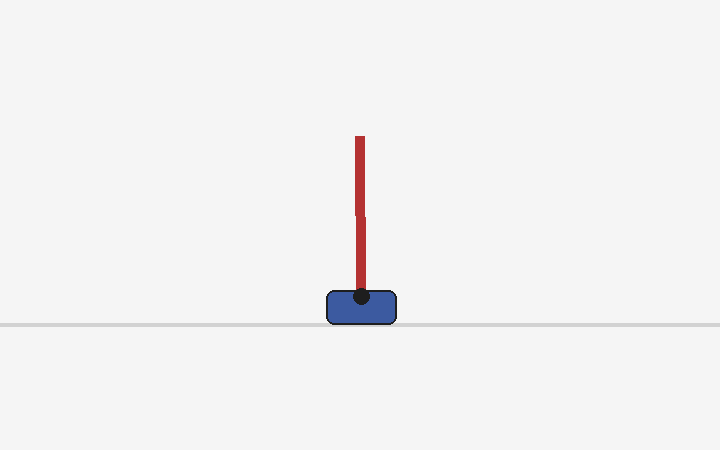

'PALSGP | r0 e2 t=859 | r=+1.000 u=-0.042 hold=197/200'

PALSGP run0 ep0 step 341/600 |    2.0 it/s |  170.1s | r=+1.00 u=+0.33 hold=200/200 upd=n
PALSGP run0 ep1 step 261/600 |    1.6 it/s |  162.5s | r=+1.00 u=-0.05 hold=198/200 upd=n
PALSGP run0 ep2 step 251/600 |    1.8 it/s |  137.3s | r=+1.00 u=+0.12 hold=193/200 upd=n
[PALSGP] run 1/10: reward=723.22 success=True first_success_t=340
PALSGP run1 ep0 step 321/600 |    1.9 it/s |  165.1s | r=+1.00 u=+0.03 hold=192/200 upd=n
PALSGP run1 ep1 step 301/600 |    1.8 it/s |  167.6s | r=+1.00 u=-0.15 hold=191/200 upd=n
PALSGP run1 ep2 step 171/600 |    1.6 it/s |  110.2s | r=+1.00 u=+0.05 hold=114/200 upd=n

In [ ]:
# ===========================
# Cell 6 — PALSGP (MPPI + Online OSGPR-VFE global, fixed-Z during episode)
#         + Local corridor subset (k-center) + anchors
#         + Success = hold upright for SUCCESS_HOLD_STEPS consecutive steps
#
# FIXES:
#   - tubeX uses tf.TensorArray (no InaccessibleTensorError)
#   - plan_tf factory is plain Python (no "returns Function" error)
#   - reduce_retracing=True
#
# Progress: TextProgress (PyCharm-friendly)
# Live PIL + concatenated replay per run (JS animation; best in notebook UI)
# ===========================

import numpy as np
import tensorflow as tf
import gpflow
import time
import sys

from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image, ImageDraw

# ---------------------------
# Preconditions
# ---------------------------
for name in ["X0", "Ydx0", "Ydxdot0", "Ydth0", "Ydthdot0"]:
    assert name in globals(), f"Run Cell 2 first: missing {name}"
for name in ["OSGPR_VFE", "train_osgpr", "prior_summary", "extract_summary_from_model", "greedy_dopt_anchors_from_K"]:
    assert name in globals(), f"Run Cell 3 first: missing {name}"
for name in ["build_pack_from_model", "kcenter_farthest_first",
             "stage_cost_tf", "tf_feature_map", "tf_wrap_angle", "is_success_state"]:
    assert name in globals(), f"Run Cell 4 first: missing {name}"
for name in ["registry_add_run", "eval_multihead_batch", "EVAL_REGISTRY"]:
    assert name in globals(), f"Run Cell 5 first: missing {name}"
assert "render_cartpole_frame_from_state" in globals(), "Run Cell 2 first (PIL renderer)"

tf.keras.backend.set_floatx("float64")
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
DTF = tf.float64

# ---------------------------
# Success-hold config
# ---------------------------
SUCCESS_HOLD_STEPS = int(globals().get("SUCCESS_HOLD_STEPS", 200))
STOP_ON_HOLD_SUCCESS = bool(globals().get("STOP_ON_HOLD_SUCCESS", True))

# ============================================================
# Text progress (PyCharm-friendly)
# ============================================================
class TextProgress:
    def __init__(self, total, prefix="", every=10):
        self.total = int(total)
        self.prefix = str(prefix)
        self.every = int(max(1, every))
        self.t0 = time.perf_counter()
        self.last_i = -1

    def update(self, i, extra=""):
        i = int(i)
        if (i == self.total - 1) or ((i % self.every) == 0 and i != self.last_i):
            dt = time.perf_counter() - self.t0
            rate = (i + 1) / max(dt, 1e-9)
            sys.stdout.write(f"\r{self.prefix}{i+1}/{self.total} | {rate:6.1f} it/s | {dt:6.1f}s {extra}")
            sys.stdout.flush()
            self.last_i = i

    def close(self):
        sys.stdout.write("\n")
        sys.stdout.flush()

# ============================================================
# Live + Replay knobs
# ============================================================
LIVE_RENDER = globals().get("LIVE_RENDER", True)
LIVE_ONLY_FIRST_RUN = globals().get("LIVE_ONLY_FIRST_RUN", True)
LIVE_ONLY_FIRST_EP  = globals().get("LIVE_ONLY_FIRST_EP", False)
LIVE_EVERY_STEPS = globals().get("LIVE_EVERY_STEPS", 3)
LIVE_MIN_DT = globals().get("LIVE_MIN_DT", 0.05)
LIVE_SIZE = globals().get("LIVE_SIZE", (720, 450))

CAPTURE_REPLAY = False
REPLAY_EVERY_STEPS = 2
REPLAY_FPS = 20
REPLAY_SIZE = (720, 450)
TITLE_HOLD_FRAMES = 12

if "LIVE_VIEWER" not in globals():
    class _LiveViewerFallback:
        def __init__(self, enabled=True, every_steps=3, min_dt=0.05, size=(720, 450)):
            self.enabled = bool(enabled)
            self.every_steps = int(every_steps)
            self.min_dt = float(min_dt)
            self.size = tuple(size)
            self._img_handle = None
            self._txt_handle = None
            self._last_step = -10**9
            self._last_t = 0.0
        def reset(self):
            self._last_step = -10**9
            self._last_t = 0.0
        def maybe_update(self, step_i, x, theta, text=""):
            if not self.enabled:
                return
            now = time.perf_counter()
            if (step_i - self._last_step) < self.every_steps:
                return
            if (now - self._last_t) < self.min_dt:
                return
            frame = render_cartpole_frame_from_state(x, theta, x_threshold=2.4, W=self.size[0], H=self.size[1])
            img = Image.fromarray(frame)
            if self._img_handle is None:
                self._img_handle = display(img, display_id=True)
                self._txt_handle = display(text, display_id=True)
            else:
                self._img_handle.update(img)
                self._txt_handle.update(text)
            self._last_step = int(step_i)
            self._last_t = now
    LIVE_VIEWER = _LiveViewerFallback(enabled=LIVE_RENDER, every_steps=LIVE_EVERY_STEPS, min_dt=LIVE_MIN_DT, size=LIVE_SIZE)

def _render_with_text(x, theta, text, W=720, H=450):
    frame = render_cartpole_frame_from_state(x, theta, x_threshold=2.4, W=W, H=H)
    img = Image.fromarray(frame)
    dr = ImageDraw.Draw(img)
    dr.rectangle([8, 8, W - 8, 44], fill=(255, 255, 255))
    dr.text((14, 14), text, fill=(0, 0, 0))
    return np.asarray(img, dtype=np.uint8)

def _title_frame(text, W=720, H=450):
    img = Image.new("RGB", (W, H), (245, 245, 245))
    dr = ImageDraw.Draw(img)
    dr.text((18, 18), text, fill=(0, 0, 0))
    return np.asarray(img, dtype=np.uint8)

def _show_replay(frames, fps=20):
    if len(frames) == 0:
        print("⚠️ No replay frames.")
        return
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(frames[0])
    ax.axis("off")
    def update(i):
        im.set_data(frames[i])
        return [im]
    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000.0 / fps, blit=True)
    plt.close(fig)
    display(HTML(ani.to_jshtml()))

# ============================================================
# Kernels (one per head)
# ============================================================
def make_kernel_6d():
    return gpflow.kernels.Matern52(lengthscales=np.ones(6, dtype=np.float64), variance=1.0)

k_dx     = make_kernel_6d()
k_dxdot  = make_kernel_6d()
k_dth    = make_kernel_6d()
k_dthdot = make_kernel_6d()

# ============================================================
# OSGPR init + fixed-Z streaming update
# ============================================================
def init_osgpr_from_prior(X, Y, Z, kernel, noise=NOISE_INIT, iters=650, lr=0.02, freeze_kernel=False):
    mu0, Su0, Kaa0, Z0 = prior_summary(kernel, Z)
    m = OSGPR_VFE(
        data=(np.asarray(X, dtype=np.float64), np.asarray(Y, dtype=np.float64)),
        kernel=kernel,
        mu_old=mu0, Su_old=Su0, Kaa_old=Kaa0, Z_old=Z0,
        Z=np.asarray(Z, dtype=np.float64),
    )
    m.likelihood.variance.assign(float(noise))
    if freeze_kernel:
        try:
            m.kernel.variance.trainable = False
            m.kernel.lengthscales.trainable = False
        except Exception:
            pass
    t_sec, _ = train_osgpr(m, iters=iters, lr=lr, clip_norm=10.0)
    m.build_predict_cache()
    return m, float(t_sec)

def osgpr_stream_update_fixedZ(model_old, X_new, Y_new, Z_fixed,
                               iters=OSGPR_ITERS_PER_UPDATE, lr=OSGPR_LR,
                               noise=NOISE_INIT, freeze_kernel=False):
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)
    m = OSGPR_VFE(
        data=(np.asarray(X_new, dtype=np.float64), np.asarray(Y_new, dtype=np.float64)),
        kernel=model_old.kernel,   # reuse kernel object
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=np.asarray(Z_fixed, dtype=np.float64),
    )
    m.likelihood.variance.assign(float(noise))
    if freeze_kernel:
        try:
            m.kernel.variance.trainable = False
            m.kernel.lengthscales.trainable = False
        except Exception:
            pass
    t_sec, _ = train_osgpr(m, iters=iters, lr=lr, clip_norm=10.0, compile_step=False)
    m.build_predict_cache()
    return m, float(t_sec)

# ============================================================
# Local Z selection: anchors + corridor k-center
# ============================================================
def select_local_Z_from_corridor(
    Xpool, pool_ids, r2_pool,
    Z_global, anchor_idx,
    m_local=M_LOCAL, m_anchors=M_ANCHORS,
    r0=CORR_R0, r1=CORR_R1,
    rng=None
):
    if rng is None:
        rng = np.random.default_rng(0)

    Z_global = np.asarray(Z_global, dtype=np.float64)
    Z_anchor = Z_global[np.asarray(anchor_idx, dtype=np.int64)]

    N = int(Xpool.shape[0])
    r2 = np.asarray(r2_pool, dtype=np.float64).reshape(-1) if N else np.zeros((0,), dtype=np.float64)
    used_fallback = False

    idx0 = np.where(r2 <= float(r0))[0]
    idx1 = np.where(r2 <= float(r1))[0]

    need = int(m_local - m_anchors)
    if N == 0:
        Z_fill = Z_global[rng.choice(Z_global.shape[0], size=need, replace=True)]
        sel_ids = np.full((need,), -1, dtype=np.int64)
        dbg = dict(inside0=0, inside1=0, used_fallback=True)
        return np.concatenate([Z_anchor, Z_fill], axis=0)[:m_local], sel_ids, dbg

    if len(idx0) >= need:
        cand = idx0
    elif len(idx1) >= need:
        cand = idx1
    else:
        cand = idx1 if len(idx1) else np.arange(N)
        used_fallback = True

    Xcand = Xpool[cand]
    idcand = pool_ids[cand]

    start_idx = int(rng.integers(0, len(Xcand)))
    sel_local = kcenter_farthest_first(Xcand, need, start_idx=start_idx)

    Z_fill = Xcand[sel_local]
    sel_ids = idcand[sel_local]

    if Z_fill.shape[0] < need:
        pad_n = need - Z_fill.shape[0]
        pad_idx = rng.choice(N, size=pad_n, replace=True)
        Z_fill = np.concatenate([Z_fill, Xpool[pad_idx]], axis=0)
        sel_ids = np.concatenate([sel_ids, pool_ids[pad_idx]], axis=0)

    dbg = dict(inside0=int(len(idx0)), inside1=int(len(idx1)), used_fallback=bool(used_fallback))
    Z_sub = np.concatenate([Z_anchor, Z_fill], axis=0)[:m_local]
    return Z_sub, sel_ids[:need], dbg

# ============================================================
# MPPI plan_tf with corridor + tubeX (TensorArray fix)
# ============================================================
@tf.function
def _predict_pack_mu_var_tf_tensors(Z, L, mw, CT, kernel, Xfeat):
    Kzx = kernel(Z, Xfeat)
    A = tf.linalg.triangular_solve(L, Kzx, lower=True)
    mu = tf.matmul(A, mw, transpose_a=True)
    mu = tf.reshape(mu, (-1,))
    kxx = kernel(Xfeat, full_cov=False)
    q = tf.reduce_sum(tf.square(A), axis=0)
    E = tf.matmul(CT, A)
    var_add = tf.reduce_sum(tf.square(E), axis=0)
    var = tf.maximum(kxx - q + var_add, tf.constant(1e-12, DTF))
    return mu, var

@tf.function
def _gp_step_batch_tf_packs(s, u,
                           Zdx,Ldx,mwdx,CTdx, likdx,
                           Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                           Zdth,Ldth,mwdth,CTdth, likdth,
                           Zdthd,Ldthd,mwdthd,CTdthd, likdthd,
                           unc_lambda):
    Xfeat = tf_feature_map(s, u)
    mu_dx,  _       = _predict_pack_mu_var_tf_tensors(Zdx,   Ldx,   mwdx,   CTdx,   k_dx,     Xfeat)
    mu_dxd, var_dxd = _predict_pack_mu_var_tf_tensors(Zdxd,  Ldxd,  mwdxd,  CTdxd,  k_dxdot,  Xfeat)
    mu_dt,  _       = _predict_pack_mu_var_tf_tensors(Zdth,  Ldth,  mwdth,  CTdth,  k_dth,    Xfeat)
    mu_dtd, _       = _predict_pack_mu_var_tf_tensors(Zdthd, Ldthd, mwdthd, CTdthd, k_dthdot, Xfeat)

    x     = s[:, 0] + mu_dx
    xdot  = s[:, 1] + mu_dxd
    th    = tf_wrap_angle(s[:, 2] + mu_dt)
    thdot = s[:, 3] + mu_dtd
    s_next = tf.stack([x, xdot, th, thdot], axis=-1)

    unc = tf.sqrt(tf.maximum(var_dxd + likdxd, tf.constant(1e-12, DTF)))
    return s_next, unc_lambda * unc, unc

@tf.function
def _corridor_min_dist_tf(Xpool, tubeX, inv_var):
    diff = tf.expand_dims(Xpool, 1) - tf.expand_dims(tubeX, 0)
    d2 = tf.reduce_sum(tf.square(diff) * tf.reshape(inv_var, (1, 1, -1)), axis=-1)
    return tf.reduce_min(d2, axis=1)

# factory MUST be plain python
def make_plan_tf(H=H, K=K, sigma=MPPI_SIGMA, lam=MPPI_LAMBDA,
                 u_min=U_MIN, u_max=U_MAX, unc_lambda=UNC_LAMBDA,
                 tube_invvar_eps=TUBE_INVVAR_EPS):

    sigma = float(sigma); lam = float(lam)
    u_min = float(u_min); u_max = float(u_max)
    unc_lambda = float(unc_lambda)
    tube_invvar_eps = float(tube_invvar_eps)

    @tf.function(reduce_retracing=True)
    def plan_tf(s0, u_mean, Xpool, corr_r0, corr_r1,
                Zdx,Ldx,mwdx,CTdx, likdx,
                Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                Zdth,Ldth,mwdth,CTdth, likdth,
                Zdthd,Ldthd,mwdthd,CTdthd, likdthd):

        s0 = tf.cast(tf.reshape(s0, (4,)), DTF)
        u_mean = tf.cast(tf.reshape(u_mean, (H,)), DTF)
        Xpool = tf.cast(Xpool, DTF)

        eps = tf.random.normal((K, H), mean=0.0, stddev=sigma, dtype=DTF)
        U = tf.clip_by_value(tf.expand_dims(u_mean, 0) + eps, u_min, u_max)

        s = tf.repeat(tf.expand_dims(s0, 0), repeats=K, axis=0)
        cost = tf.zeros((K,), dtype=DTF)
        unc_sum = tf.zeros((K,), dtype=DTF)

        for t in tf.range(H):
            u_t = U[:, t]
            s, unc_bonus, unc = _gp_step_batch_tf_packs(
                s, u_t,
                Zdx,Ldx,mwdx,CTdx, likdx,
                Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                Zdth,Ldth,mwdth,CTdth, likdth,
                Zdthd,Ldthd,mwdthd,CTdthd, likdthd,
                tf.constant(unc_lambda, DTF),
            )
            cost = cost + stage_cost_tf(s, u_t) + unc_bonus
            unc_sum = unc_sum + unc

        beta = tf.reduce_min(cost)
        w = tf.exp(-(cost - beta) / tf.constant(lam, DTF))
        w_sum = tf.reduce_sum(w) + tf.constant(1e-12, DTF)

        u_mean_new = tf.reduce_sum(tf.expand_dims(w, 1) * U, axis=0) / w_sum
        u0 = u_mean_new[0]
        unc_w = tf.reduce_sum(w * (unc_sum / tf.cast(H, DTF))) / w_sum

        # tubeX via TensorArray (scope-safe)
        sT = tf.reshape(s0, (1, 4))
        ta = tf.TensorArray(DTF, size=H, element_shape=(6,))
        for t in tf.range(H):
            u_t = tf.reshape(u_mean_new[t], (1,))
            Xft = tf_feature_map(sT, u_t)
            ta = ta.write(t, tf.reshape(Xft, (6,)))
            sT, _, _ = _gp_step_batch_tf_packs(
                sT, u_t,
                Zdx,Ldx,mwdx,CTdx, likdx,
                Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                Zdth,Ldth,mwdth,CTdth, likdth,
                Zdthd,Ldthd,mwdthd,CTdthd, likdthd,
                tf.constant(0.0, DTF),
            )
        tubeX = ta.stack()  # (H,6)

        tube_var = tf.math.reduce_variance(tubeX, axis=0)
        inv_var = 1.0 / (tube_var + tf.constant(tube_invvar_eps, DTF))

        Npool = tf.shape(Xpool)[0]
        r2_pool = tf.cond(
            Npool > 0,
            lambda: _corridor_min_dist_tf(Xpool, tubeX, inv_var),
            lambda: tf.zeros((0,), dtype=DTF),
        )

        inside0 = tf.reduce_sum(tf.cast(r2_pool <= tf.cast(corr_r0, DTF), tf.int32))
        inside1 = tf.reduce_sum(tf.cast(r2_pool <= tf.cast(corr_r1, DTF), tf.int32))
        corr_dbg = tf.stack([tf.cast(Npool, tf.float64),
                             tf.cast(inside0, tf.float64),
                             tf.cast(inside1, tf.float64)], axis=0)

        return u0, u_mean_new, tubeX, unc_w, r2_pool, inv_var, corr_dbg

    return plan_tf

plan_tf = make_plan_tf()

# ============================================================
# Packs at Z_sub for all 4 heads
# ============================================================
def packs_from_Zsub(models, Z_sub):
    m_dx, m_dxdot, m_dth, m_dthdot = models
    p_dx     = build_pack_from_model(m_dx,     Z_sub, jitter=1e-6, use_cached=True)
    p_dxdot  = build_pack_from_model(m_dxdot,  Z_sub, jitter=1e-6, use_cached=True)
    p_dth    = build_pack_from_model(m_dth,    Z_sub, jitter=1e-6, use_cached=True)
    p_dthdot = build_pack_from_model(m_dthdot, Z_sub, jitter=1e-6, use_cached=True)
    return (
        p_dx.Z, p_dx.L, p_dx.m_w, p_dx.C_T, p_dx.lik_var,
        p_dxdot.Z, p_dxdot.L, p_dxdot.m_w, p_dxdot.C_T, p_dxdot.lik_var,
        p_dth.Z, p_dth.L, p_dth.m_w, p_dth.C_T, p_dth.lik_var,
        p_dthdot.Z, p_dthdot.L, p_dthdot.m_w, p_dthdot.C_T, p_dthdot.lik_var,
    )

# ============================================================
# Episode-end refit Z_GLOBAL (D-opt) on replay candidates
# ============================================================
def refit_Z_global_multihead(Xcand, M_new, kernels, lam=1e-6, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    Xcand = np.asarray(Xcand, dtype=np.float64)
    N = Xcand.shape[0]
    if N <= M_new:
        return Xcand.copy()

    Ncap = min(N, 1800)
    if N > Ncap:
        idx = rng.choice(N, size=Ncap, replace=False)
        Xuse = Xcand[idx]
    else:
        Xuse = Xcand

    Ksum = None
    for k in kernels:
        Kk = k.K(Xuse).numpy()
        Ksum = Kk if Ksum is None else (Ksum + Kk)
    Kavg = Ksum / float(len(kernels))
    Kavg = 0.5 * (Kavg + Kavg.T) + float(lam) * np.eye(Kavg.shape[0], dtype=np.float64)

    sel = greedy_dopt_anchors_from_K(Kavg, m_anchors=int(M_new), lam=lam)
    return Xuse[sel]

# ============================================================
# MAIN: PALSGP
# ============================================================
METHOD = "PALSGP"
print(f"\n===========================\nRunning {METHOD} (hold {SUCCESS_HOLD_STEPS} steps)\n===========================\n")

POOL_MAX = 5000
REFIT_REPLAY_MAX = 4000

# Init Z_GLOBAL from random data
rng0 = np.random.default_rng(SEED_BASE)
M_GLOBAL = int(min(M_GLOBAL_INIT, X0.shape[0]))
Z_GLOBAL = np.asarray(X0[rng0.choice(X0.shape[0], size=M_GLOBAL, replace=False)], dtype=np.float64)

# anchors from dxdot kernel
Kzz_init = k_dxdot.K(Z_GLOBAL).numpy()
anchor_idx = greedy_dopt_anchors_from_K(Kzz_init, m_anchors=M_ANCHORS, lam=1e-6)
print("✅ Z_GLOBAL init:", Z_GLOBAL.shape, "anchors:", anchor_idx.shape)

# initial global training
print("Training initial global OSGPR models...")
m_dx,     _ = init_osgpr_from_prior(X0, Ydx0,     Z_GLOBAL, k_dx,     noise=NOISE_INIT, iters=650, lr=0.02)
m_dxdot,  _ = init_osgpr_from_prior(X0, Ydxdot0,  Z_GLOBAL, k_dxdot,  noise=NOISE_INIT, iters=650, lr=0.02)
m_dth,    _ = init_osgpr_from_prior(X0, Ydth0,    Z_GLOBAL, k_dth,    noise=NOISE_INIT, iters=650, lr=0.02)
m_dthdot, _ = init_osgpr_from_prior(X0, Ydthdot0, Z_GLOBAL, k_dthdot, noise=NOISE_INIT, iters=650, lr=0.02)

for run in range(N_RUNS):
    seed = SEED_BASE + run
    rng = np.random.default_rng(seed)
    env = make_env(render_mode=None, seed=seed, max_episode_steps=MAX_STEPS_PER_EP, start_down=True, edge_respawn=True)
    do_live = bool(LIVE_RENDER and ((not LIVE_ONLY_FIRST_RUN) or (run == 0)))

    run_frames = []
    if CAPTURE_REPLAY:
        run_frames.extend([_title_frame(f"{METHOD} | RUN {run} | start", W=REPLAY_SIZE[0], H=REPLAY_SIZE[1])] * TITLE_HOLD_FRAMES)

    # replay buffer for refit/training
    Xmem = [np.asarray(X0[i], dtype=np.float64) for i in range(X0.shape[0])]
    Ydx_mem     = [float(Ydx0[i, 0]) for i in range(Ydx0.shape[0])]
    Ydxdot_mem  = [float(Ydxdot0[i, 0]) for i in range(Ydxdot0.shape[0])]
    Ydth_mem    = [float(Ydth0[i, 0]) for i in range(Ydth0.shape[0])]
    Ydthdot_mem = [float(Ydthdot0[i, 0]) for i in range(Ydthdot0.shape[0])]
    mem_ids = list(range(len(Xmem)))
    next_id = int(len(Xmem))

    # online update buffer
    Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []

    u_mean = np.zeros((H,), dtype=np.float64)

    # traces
    pred_time_step, train_time_step, rebuild_time_step, wall_time_step, vis_time_step = [], [], [], [], []
    u_exec_step, unc_exec_step = [], []
    local_overlap_step, local_rebuild_flag_step, update_flag_step = [], [], []
    corr_poolN_step, corr_inside0_step, corr_inside1_step, corr_used_fallback_step = [], [], [], []
    update_t_global, update_rmse_mean, update_nlpd_mean, update_cover2_mean, update_std_mean = [], [], [], [], []

    # episode metrics
    ep_returns, ep_lengths, ep_success, ep_first_success_t_global = [], [], [], []
    ep_control_l2, ep_u_abs_mean, ep_unc_mean, ep_unc_max = [], [], [], []
    ep_hold_max_list = []

    total_reward_run = 0.0
    run_success = False
    first_success_t = None

    t_global = 0

    # init local packs
    models = (m_dx, m_dxdot, m_dth, m_dthdot)
    Z_sub0 = np.concatenate(
        [Z_GLOBAL[anchor_idx],
         Z_GLOBAL[rng.choice(Z_GLOBAL.shape[0], size=max(M_LOCAL - M_ANCHORS, 1), replace=True)]],
        axis=0
    )[:M_LOCAL]
    pack_tensors = packs_from_Zsub(models, Z_sub0)
    last_sel_ids = np.full((M_LOCAL - M_ANCHORS,), -999, dtype=np.int64)
    last_rebuild_t = 0

    for ep in range(N_EPISODES_PER_RUN):
        obs, _ = env.reset(seed=int(rng.integers(0, 10**9)))
        x, xdot, th, thdot = obs_to_state(obs)

        if do_live and (not LIVE_ONLY_FIRST_EP or ep == 0):
            LIVE_VIEWER.reset()
        if CAPTURE_REPLAY:
            run_frames.extend([_title_frame(f"{METHOD} | RUN {run} | EP {ep}", W=REPLAY_SIZE[0], H=REPLAY_SIZE[1])] * TITLE_HOLD_FRAMES)

        # episode accum
        ep_reward = 0.0
        ep_steps = 0
        ep_u2_sum = 0.0
        ep_u_abs_sum = 0.0
        ep_unc_sum = 0.0
        ep_unc_max_v = 0.0

        # HOLD success tracking
        hold_count = 0
        hold_max = 0
        ep_hold_complete_t = None

        ep_prog = TextProgress(MAX_STEPS_PER_EP, prefix=f"{METHOD} run{run} ep{ep} step ", every=10)

        for step in range(MAX_STEPS_PER_EP):
            # corridor candidate pool from recent replay
            if len(Xmem) > 0:
                lo = max(0, len(Xmem) - POOL_MAX)
                Xpool_np = np.asarray(Xmem[lo:], dtype=np.float64)
                pool_ids_np = np.asarray(mem_ids[lo:], dtype=np.int64)
            else:
                Xpool_np = np.zeros((0, 6), dtype=np.float64)
                pool_ids_np = np.zeros((0,), dtype=np.int64)

            # plan
            tp0 = time.perf_counter()
            s0 = np.array([x, xdot, th, thdot], dtype=np.float64)
            u0_tf, u_mean_new_tf, _, unc_w_tf, r2_pool_tf, _, corr_dbg_tf = plan_tf(
                s0, u_mean, Xpool_np, float(CORR_R0), float(CORR_R1),
                *pack_tensors
            )
            u0 = float(u0_tf.numpy())
            u_mean_new = u_mean_new_tf.numpy()

            # receding horizon
            u_mean = np.roll(u_mean_new, -1)
            u_mean[-1] = 0.0

            r2_pool = r2_pool_tf.numpy()
            corr_dbg = corr_dbg_tf.numpy()
            pred_dt = float(time.perf_counter() - tp0)

            # execute
            obs1, r, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
            x1, xdot1, th1, thdot1 = obs_to_state(obs1)

            # live
            if do_live and (not LIVE_ONLY_FIRST_EP or ep == 0):
                LIVE_VIEWER.maybe_update(
                    step_i=t_global, x=x1, theta=th1,
                    text=f"{METHOD} | r{run} e{ep} t={t_global} | r={float(r):+.3f} u={u0:+.3f} hold={hold_count}/{SUCCESS_HOLD_STEPS}"
                )

            # replay frames
            if CAPTURE_REPLAY and ((t_global % REPLAY_EVERY_STEPS) == 0):
                run_frames.append(_render_with_text(
                    x1, th1,
                    text=f"{METHOD} r{run} e{ep} t{t_global} | r={float(r):+.2f} u={u0:+.2f} hold={hold_count}",
                    W=REPLAY_SIZE[0], H=REPLAY_SIZE[1]
                ))

            # ---- HOLD success logic ----
            succ_inst = is_success_state(
                x1, xdot1, th1, thdot1,
                cos_th_min=SUCCESS_COS_TH_MIN,
                x_abs_max=SUCCESS_X_ABS_MAX,
                xdot_abs_max=SUCCESS_XDOT_ABS_MAX,
                thdot_abs_max=SUCCESS_THDOT_ABS_MAX
            )

            if bool(info.get("respawned", False)):
                hold_count = 0
            else:
                hold_count = (hold_count + 1) if succ_inst else 0

            hold_max = max(hold_max, hold_count)
            succ_hold = (hold_count >= SUCCESS_HOLD_STEPS)

            if succ_hold and (ep_hold_complete_t is None):
                ep_hold_complete_t = int(t_global)
            if succ_hold and (not run_success):
                run_success = True
                first_success_t = int(t_global)

            # transition
            feat = state_to_features(x, xdot, th, thdot, u0).astype(np.float64)
            d_x = (x1 - x)
            d_xdot = (xdot1 - xdot)
            d_th = wrap_pi(th1 - th)
            d_thdot = (thdot1 - thdot)

            if not bool(info.get("respawned", False)):
                Xbuf.append(feat)
                ydx_buf.append([d_x])
                ydxdot_buf.append([d_xdot])
                ydth_buf.append([d_th])
                ydthdot_buf.append([d_thdot])

                Xmem.append(feat)
                Ydx_mem.append(float(d_x))
                Ydxdot_mem.append(float(d_xdot))
                Ydth_mem.append(float(d_th))
                Ydthdot_mem.append(float(d_thdot))
                mem_ids.append(next_id)
                next_id += 1

            # episode accumulators
            ep_reward += float(r); ep_steps += 1
            ep_u2_sum += u0*u0; ep_u_abs_sum += abs(u0)
            ep_unc_sum += float(unc_w_tf.numpy()); ep_unc_max_v = max(ep_unc_max_v, float(unc_w_tf.numpy()))
            total_reward_run += float(r)

            # online update every UPDATE_EVERY
            trn_dt = 0.0
            reb_dt = 0.0
            did_update = False

            if ((t_global + 1) % int(UPDATE_EVERY) == 0) and (len(Xbuf) > 0):
                did_update = True
                Xnew = np.asarray(Xbuf, dtype=np.float64)
                ydx_new     = np.asarray(ydx_buf, dtype=np.float64)
                ydxdot_new  = np.asarray(ydxdot_buf, dtype=np.float64)
                ydth_new    = np.asarray(ydth_buf, dtype=np.float64)
                ydthdot_new = np.asarray(ydthdot_buf, dtype=np.float64)

                tu0 = time.perf_counter()
                m_dx,     _ = osgpr_stream_update_fixedZ(m_dx,     Xnew, ydx_new,     Z_GLOBAL)
                m_dxdot,  _ = osgpr_stream_update_fixedZ(m_dxdot,  Xnew, ydxdot_new,  Z_GLOBAL)
                m_dth,    _ = osgpr_stream_update_fixedZ(m_dth,    Xnew, ydth_new,    Z_GLOBAL)
                m_dthdot, _ = osgpr_stream_update_fixedZ(m_dthdot, Xnew, ydthdot_new, Z_GLOBAL)
                trn_dt = float(time.perf_counter() - tu0)
                models = (m_dx, m_dxdot, m_dth, m_dthdot)

                try:
                    met = eval_multihead_batch(
                        [m_dx, m_dxdot, m_dth, m_dthdot],
                        Xnew, [ydx_new, ydxdot_new, ydth_new, ydthdot_new],
                        add_likelihood_var=True
                    )
                    update_t_global.append(int(t_global))
                    update_rmse_mean.append(float(met["rmse_mean"]))
                    update_nlpd_mean.append(float(met["nlpd_mean"]))
                    update_cover2_mean.append(float(met["cover2_mean"]))
                    update_std_mean.append(float(met["std_mean_mean"]))
                except Exception:
                    update_t_global.append(int(t_global))
                    update_rmse_mean.append(np.nan)
                    update_nlpd_mean.append(np.nan)
                    update_cover2_mean.append(np.nan)
                    update_std_mean.append(np.nan)

                Xbuf.clear(); ydx_buf.clear(); ydxdot_buf.clear(); ydth_buf.clear(); ydthdot_buf.clear()

            # local rebuild policy (force after update)
            if len(pool_ids_np) > 0 and len(last_sel_ids) > 0 and np.all(last_sel_ids >= 0):
                overlap = float(np.mean(np.isin(last_sel_ids, pool_ids_np)))
            else:
                overlap = 0.0

            must_rebuild = (
                did_update or
                ((t_global - last_rebuild_t) >= int(LOCAL_REBUILD_EVERY)) or
                (overlap < float(LOCAL_OVERLAP_TRIG))
            )

            inside0 = int(corr_dbg[1]) if corr_dbg.size else 0
            inside1 = int(corr_dbg[2]) if corr_dbg.size else 0
            poolN = int(corr_dbg[0]) if corr_dbg.size else int(len(Xpool_np))
            used_fallback = False

            if must_rebuild:
                trb0 = time.perf_counter()
                Z_sub, sel_ids, dbg = select_local_Z_from_corridor(
                    Xpool_np, pool_ids_np, r2_pool,
                    Z_GLOBAL, anchor_idx,
                    m_local=M_LOCAL, m_anchors=M_ANCHORS,
                    r0=CORR_R0, r1=CORR_R1,
                    rng=rng
                )
                pack_tensors = packs_from_Zsub(models, Z_sub)
                last_sel_ids = np.asarray(sel_ids, dtype=np.int64)
                last_rebuild_t = int(t_global)
                reb_dt = float(time.perf_counter() - trb0)

                inside0 = int(dbg["inside0"])
                inside1 = int(dbg["inside1"])
                used_fallback = bool(dbg["used_fallback"])

            # logs
            wall_dt = pred_dt + trn_dt + reb_dt
            pred_time_step.append(pred_dt)
            train_time_step.append(trn_dt)
            rebuild_time_step.append(reb_dt)
            wall_time_step.append(wall_dt)
            vis_time_step.append(0.0)

            u_exec_step.append(float(u0))
            unc_exec_step.append(float(unc_w_tf.numpy()))
            local_overlap_step.append(float(overlap))
            local_rebuild_flag_step.append(1.0 if must_rebuild else 0.0)
            update_flag_step.append(1.0 if did_update else 0.0)

            corr_poolN_step.append(float(poolN))
            corr_inside0_step.append(float(inside0))
            corr_inside1_step.append(float(inside1))
            corr_used_fallback_step.append(1.0 if used_fallback else 0.0)

            ep_prog.update(step, extra=f"| r={float(r):+.2f} u={u0:+.2f} hold={hold_count}/{SUCCESS_HOLD_STEPS} upd={'Y' if did_update else 'n'}")

            # advance
            x, xdot, th, thdot = x1, xdot1, th1, thdot1
            t_global += 1

            if STOP_ON_HOLD_SUCCESS and succ_hold:
                break

        ep_prog.close()

        # episode stats
        ep_returns.append(float(ep_reward))
        ep_lengths.append(int(ep_steps))
        ep_success.append(bool(ep_hold_complete_t is not None))
        ep_first_success_t_global.append(int(ep_hold_complete_t) if ep_hold_complete_t is not None else None)
        ep_control_l2.append(float(ep_u2_sum))
        ep_u_abs_mean.append(float(ep_u_abs_sum / max(ep_steps, 1)))
        ep_unc_mean.append(float(ep_unc_sum / max(ep_steps, 1)))
        ep_unc_max.append(float(ep_unc_max_v))
        ep_hold_max_list.append(int(hold_max))

        # episode-end refit Z + reinit globals
        if len(Xmem) > REFIT_REPLAY_MAX:
            idxr = rng.choice(len(Xmem), size=REFIT_REPLAY_MAX, replace=False)
        else:
            idxr = np.arange(len(Xmem))

        Xr = np.asarray([Xmem[i] for i in idxr], dtype=np.float64)
        ydx_r     = np.asarray([[Ydx_mem[i]] for i in idxr], dtype=np.float64)
        ydxdot_r  = np.asarray([[Ydxdot_mem[i]] for i in idxr], dtype=np.float64)
        ydth_r    = np.asarray([[Ydth_mem[i]] for i in idxr], dtype=np.float64)
        ydthdot_r = np.asarray([[Ydthdot_mem[i]] for i in idxr], dtype=np.float64)

        Z_GLOBAL = refit_Z_global_multihead(
            Xr, M_new=int(M_GLOBAL),
            kernels=[k_dx, k_dxdot, k_dth, k_dthdot],
            lam=1e-6, rng=rng
        )
        Kzz_new = k_dxdot.K(Z_GLOBAL).numpy()
        anchor_idx = greedy_dopt_anchors_from_K(Kzz_new, m_anchors=M_ANCHORS, lam=1e-6)

        m_dx,     _ = init_osgpr_from_prior(Xr, ydx_r,     Z_GLOBAL, k_dx,     noise=NOISE_INIT, iters=250, lr=0.02)
        m_dxdot,  _ = init_osgpr_from_prior(Xr, ydxdot_r,  Z_GLOBAL, k_dxdot,  noise=NOISE_INIT, iters=250, lr=0.02)
        m_dth,    _ = init_osgpr_from_prior(Xr, ydth_r,    Z_GLOBAL, k_dth,    noise=NOISE_INIT, iters=250, lr=0.02)
        m_dthdot, _ = init_osgpr_from_prior(Xr, ydthdot_r, Z_GLOBAL, k_dthdot, noise=NOISE_INIT, iters=250, lr=0.02)
        models = (m_dx, m_dxdot, m_dth, m_dthdot)

        # rebuild locals after refit
        Z_sub_ep = np.concatenate(
            [Z_GLOBAL[anchor_idx],
             Z_GLOBAL[rng.choice(Z_GLOBAL.shape[0], size=max(M_LOCAL - M_ANCHORS, 1), replace=True)]],
            axis=0
        )[:M_LOCAL]
        pack_tensors = packs_from_Zsub(models, Z_sub_ep)
        last_sel_ids = np.full((M_LOCAL - M_ANCHORS,), -999, dtype=np.int64)
        last_rebuild_t = int(t_global)

    env.close()

    # registry
    run_stats = dict(
        total_reward=float(total_reward_run),
        success=bool(run_success),
        first_success_t_global=int(first_success_t) if first_success_t is not None else None,

        ep_returns=ep_returns,
        ep_lengths=ep_lengths,
        ep_success=ep_success,
        ep_first_success_t_global=ep_first_success_t_global,
        ep_control_l2=ep_control_l2,
        ep_u_abs_mean=ep_u_abs_mean,
        ep_unc_mean=ep_unc_mean,
        ep_unc_max=ep_unc_max,
        ep_hold_max=ep_hold_max_list,
    )

    run_traces = dict(
        wall_time_step=wall_time_step,
        pred_time_step=pred_time_step,
        train_time_step=train_time_step,
        rebuild_time_step=rebuild_time_step,
        vis_time_step=vis_time_step,

        u_exec_step=u_exec_step,
        unc_exec_step=unc_exec_step,

        local_overlap_step=local_overlap_step,
        local_rebuild_flag_step=local_rebuild_flag_step,
        update_flag_step=update_flag_step,

        corr_poolN_step=corr_poolN_step,
        corr_inside0_step=corr_inside0_step,
        corr_inside1_step=corr_inside1_step,
        corr_used_fallback_step=corr_used_fallback_step,

        update_t_global=update_t_global,
        update_rmse_mean=update_rmse_mean,
        update_nlpd_mean=update_nlpd_mean,
        update_cover2_mean=update_cover2_mean,
        update_std_mean=update_std_mean,
    )

    registry_add_run(METHOD, run_stats, run_traces)

    print(f"[{METHOD}] run {run+1}/{N_RUNS}: reward={total_reward_run:.2f} success={run_success} first_success_t={first_success_t}")

    if CAPTURE_REPLAY:
        print(f"\n▶️ Replay: {METHOD} RUN {run} (all episodes) | frames={len(run_frames)} | fps={REPLAY_FPS}")
        _show_replay(run_frames, fps=REPLAY_FPS)

print(f"\n✅ {METHOD} finished. Registry runs = {len(EVAL_REGISTRY[METHOD]['run_stats'])}")


In [ ]:
# ===========================
# Cell 7 — SVGP_GLOBAL (MPPI + SVGP online training)
# Success = hold upright for SUCCESS_HOLD_STEPS consecutive steps
# Progress: TextProgress; Live + replay
# ===========================

import numpy as np
import tensorflow as tf
import gpflow
import time
import sys

from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image, ImageDraw

# Preconditions
for name in ["X0", "Ydx0", "Ydxdot0", "Ydth0", "Ydthdot0"]:
    assert name in globals(), f"Run Cell 2 first: missing {name}"
for name in ["build_pack_from_model", "stage_cost_tf", "tf_feature_map", "tf_wrap_angle", "is_success_state"]:
    assert name in globals(), f"Run Cell 4 first: missing {name}"
for name in ["registry_add_run", "eval_multihead_batch", "EVAL_REGISTRY"]:
    assert name in globals(), f"Run Cell 5 first: missing {name}"
assert "render_cartpole_frame_from_state" in globals(), "Run Cell 2 first (PIL renderer)"

tf.keras.backend.set_floatx("float64")
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
DTF = tf.float64

SUCCESS_HOLD_STEPS = int(globals().get("SUCCESS_HOLD_STEPS", 200))
STOP_ON_HOLD_SUCCESS = bool(globals().get("STOP_ON_HOLD_SUCCESS", True))

class TextProgress:
    def __init__(self, total, prefix="", every=10):
        self.total = int(total); self.prefix = str(prefix); self.every = int(max(1, every))
        self.t0 = time.perf_counter(); self.last_i = -1
    def update(self, i, extra=""):
        i = int(i)
        if (i == self.total - 1) or ((i % self.every) == 0 and i != self.last_i):
            dt = time.perf_counter() - self.t0
            rate = (i + 1) / max(dt, 1e-9)
            sys.stdout.write(f"\r{self.prefix}{i+1}/{self.total} | {rate:6.1f} it/s | {dt:6.1f}s {extra}")
            sys.stdout.flush()
            self.last_i = i
    def close(self):
        sys.stdout.write("\n"); sys.stdout.flush()

LIVE_RENDER = globals().get("LIVE_RENDER", True)
LIVE_ONLY_FIRST_RUN = globals().get("LIVE_ONLY_FIRST_RUN", True)
LIVE_ONLY_FIRST_EP  = globals().get("LIVE_ONLY_FIRST_EP", False)
LIVE_EVERY_STEPS = globals().get("LIVE_EVERY_STEPS", 3)
LIVE_MIN_DT = globals().get("LIVE_MIN_DT", 0.05)
LIVE_SIZE = globals().get("LIVE_SIZE", (720, 450))

CAPTURE_REPLAY = False
REPLAY_EVERY_STEPS = 2
REPLAY_FPS = 20
REPLAY_SIZE = (720, 450)
TITLE_HOLD_FRAMES = 12

if "LIVE_VIEWER" not in globals():
    class _LiveViewerFallback:
        def __init__(self, enabled=True, every_steps=3, min_dt=0.05, size=(720, 450)):
            self.enabled = bool(enabled); self.every_steps = int(every_steps); self.min_dt = float(min_dt); self.size = tuple(size)
            self._img_handle = None; self._txt_handle = None; self._last_step = -10**9; self._last_t = 0.0
        def reset(self):
            self._last_step = -10**9; self._last_t = 0.0
        def maybe_update(self, step_i, x, theta, text=""):
            if not self.enabled: return
            now = time.perf_counter()
            if (step_i - self._last_step) < self.every_steps: return
            if (now - self._last_t) < self.min_dt: return
            frame = render_cartpole_frame_from_state(x, theta, x_threshold=2.4, W=self.size[0], H=self.size[1])
            img = Image.fromarray(frame)
            if self._img_handle is None:
                self._img_handle = display(img, display_id=True)
                self._txt_handle = display(text, display_id=True)
            else:
                self._img_handle.update(img); self._txt_handle.update(text)
            self._last_step = int(step_i); self._last_t = now
    LIVE_VIEWER = _LiveViewerFallback(enabled=LIVE_RENDER, every_steps=LIVE_EVERY_STEPS, min_dt=LIVE_MIN_DT, size=LIVE_SIZE)

def _render_with_text(x, theta, text, W=720, H=450):
    frame = render_cartpole_frame_from_state(x, theta, x_threshold=2.4, W=W, H=H)
    img = Image.fromarray(frame)
    dr = ImageDraw.Draw(img)
    dr.rectangle([8, 8, W - 8, 44], fill=(255, 255, 255))
    dr.text((14, 14), text, fill=(0, 0, 0))
    return np.asarray(img, dtype=np.uint8)

def _title_frame(text, W=720, H=450):
    img = Image.new("RGB", (W, H), (245, 245, 245))
    dr = ImageDraw.Draw(img); dr.text((18, 18), text, fill=(0, 0, 0))
    return np.asarray(img, dtype=np.uint8)

def _show_replay(frames, fps=20):
    if len(frames) == 0:
        print("⚠️ No replay frames.")
        return
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(frames[0]); ax.axis("off")
    def update(i):
        im.set_data(frames[i]); return [im]
    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000.0 / fps, blit=True)
    plt.close(fig); display(HTML(ani.to_jshtml()))

# Kernels
def make_kernel_6d():
    return gpflow.kernels.Matern52(lengthscales=np.ones(6, dtype=np.float64), variance=1.0)

k_dx     = make_kernel_6d()
k_dxdot  = make_kernel_6d()
k_dth    = make_kernel_6d()
k_dthdot = make_kernel_6d()

# SVGP builders
def make_svgp(Z, kernel, noise=NOISE_INIT, train_hypers=False):
    Z = np.asarray(Z, dtype=np.float64)
    m = gpflow.models.SVGP(
        kernel=kernel,
        likelihood=gpflow.likelihoods.Gaussian(variance=float(noise)),
        inducing_variable=gpflow.inducing_variables.InducingPoints(Z),
        num_latent_gps=1,
        mean_function=None,
        whiten=True,
        q_diag=False,
    )
    gpflow.set_trainable(m.inducing_variable, False)
    if not train_hypers:
        try:
            m.kernel.variance.trainable = False
            m.kernel.lengthscales.trainable = False
        except Exception:
            pass
    return m

def svgp_train_steps(model, X, Y, steps=80, lr=0.02, clip_norm=10.0):
    opt = tf.keras.optimizers.Adam(lr)
    Xt = tf.convert_to_tensor(np.asarray(X, dtype=np.float64))
    Yt = tf.convert_to_tensor(np.asarray(Y, dtype=np.float64))
    @tf.function
    def train_step():
        with tf.GradientTape() as tape:
            loss = -model.elbo((Xt, Yt))
        grads = tape.gradient(loss, model.trainable_variables)
        if clip_norm is not None:
            grads = [tf.clip_by_norm(g, clip_norm) if g is not None else None for g in grads]
        opt.apply_gradients([(g, v) for g, v in zip(grads, model.trainable_variables) if g is not None])
        return loss
    t0 = time.perf_counter()
    last = None
    for _ in range(int(steps)):
        last = train_step()
    return float(time.perf_counter() - t0)

# MPPI plan_tf (simple, no corridor/tube) using packs
@tf.function
def _predict_pack_mu_var_tf_tensors(Z, L, mw, CT, kernel, Xfeat):
    Kzx = kernel(Z, Xfeat)
    A = tf.linalg.triangular_solve(L, Kzx, lower=True)
    mu = tf.matmul(A, mw, transpose_a=True); mu = tf.reshape(mu, (-1,))
    kxx = kernel(Xfeat, full_cov=False)
    q = tf.reduce_sum(tf.square(A), axis=0)
    E = tf.matmul(CT, A)
    var_add = tf.reduce_sum(tf.square(E), axis=0)
    var = tf.maximum(kxx - q + var_add, tf.constant(1e-12, DTF))
    return mu, var

@tf.function
def _gp_step_batch_tf_packs(s, u,
                           Zdx,Ldx,mwdx,CTdx, likdx,
                           Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                           Zdth,Ldth,mwdth,CTdth, likdth,
                           Zdthd,Ldthd,mwdthd,CTdthd, likdthd,
                           unc_lambda):
    Xfeat = tf_feature_map(s, u)
    mu_dx,  _       = _predict_pack_mu_var_tf_tensors(Zdx,   Ldx,   mwdx,   CTdx,   k_dx,     Xfeat)
    mu_dxd, var_dxd = _predict_pack_mu_var_tf_tensors(Zdxd,  Ldxd,  mwdxd,  CTdxd,  k_dxdot,  Xfeat)
    mu_dt,  _       = _predict_pack_mu_var_tf_tensors(Zdth,  Ldth,  mwdth,  CTdth,  k_dth,    Xfeat)
    mu_dtd, _       = _predict_pack_mu_var_tf_tensors(Zdthd, Ldthd, mwdthd, CTdthd, k_dthdot, Xfeat)
    x     = s[:, 0] + mu_dx
    xdot  = s[:, 1] + mu_dxd
    th    = tf_wrap_angle(s[:, 2] + mu_dt)
    thdot = s[:, 3] + mu_dtd
    s_next = tf.stack([x, xdot, th, thdot], axis=-1)
    unc = tf.sqrt(tf.maximum(var_dxd + likdxd, tf.constant(1e-12, DTF)))
    return s_next, unc_lambda * unc, unc

def make_plan_tf_simple(H=H, K=K, sigma=MPPI_SIGMA, lam=MPPI_LAMBDA,
                        u_min=U_MIN, u_max=U_MAX, unc_lambda=UNC_LAMBDA):
    sigma = float(sigma); lam = float(lam)
    u_min = float(u_min); u_max = float(u_max)
    unc_lambda = float(unc_lambda)

    @tf.function(reduce_retracing=True)
    def plan_tf(s0, u_mean,
                Zdx,Ldx,mwdx,CTdx, likdx,
                Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                Zdth,Ldth,mwdth,CTdth, likdth,
                Zdthd,Ldthd,mwdthd,CTdthd, likdthd):
        s0 = tf.cast(tf.reshape(s0, (4,)), DTF)
        u_mean = tf.cast(tf.reshape(u_mean, (H,)), DTF)

        eps = tf.random.normal((K, H), mean=0.0, stddev=sigma, dtype=DTF)
        U = tf.clip_by_value(tf.expand_dims(u_mean, 0) + eps, u_min, u_max)

        s = tf.repeat(tf.expand_dims(s0, 0), repeats=K, axis=0)
        cost = tf.zeros((K,), dtype=DTF)
        unc_sum = tf.zeros((K,), dtype=DTF)

        for t in tf.range(H):
            u_t = U[:, t]
            s, unc_bonus, unc = _gp_step_batch_tf_packs(
                s, u_t,
                Zdx,Ldx,mwdx,CTdx, likdx,
                Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                Zdth,Ldth,mwdth,CTdth, likdth,
                Zdthd,Ldthd,mwdthd,CTdthd, likdthd,
                tf.constant(unc_lambda, DTF),
            )
            cost = cost + stage_cost_tf(s, u_t) + unc_bonus
            unc_sum = unc_sum + unc

        beta = tf.reduce_min(cost)
        w = tf.exp(-(cost - beta) / tf.constant(lam, DTF))
        w_sum = tf.reduce_sum(w) + tf.constant(1e-12, DTF)

        u_mean_new = tf.reduce_sum(tf.expand_dims(w, 1) * U, axis=0) / w_sum
        u0 = u_mean_new[0]
        unc_w = tf.reduce_sum(w * (unc_sum / tf.cast(H, DTF))) / w_sum
        return u0, u_mean_new, unc_w
    return plan_tf

plan_tf = make_plan_tf_simple()

def packs_from_global(models, Z_global):
    m_dx, m_dxdot, m_dth, m_dthdot = models
    p_dx     = build_pack_from_model(m_dx,     Z_global, jitter=1e-6, use_cached=False)
    p_dxdot  = build_pack_from_model(m_dxdot,  Z_global, jitter=1e-6, use_cached=False)
    p_dth    = build_pack_from_model(m_dth,    Z_global, jitter=1e-6, use_cached=False)
    p_dthdot = build_pack_from_model(m_dthdot, Z_global, jitter=1e-6, use_cached=False)
    return (
        p_dx.Z, p_dx.L, p_dx.m_w, p_dx.C_T, p_dx.lik_var,
        p_dxdot.Z, p_dxdot.L, p_dxdot.m_w, p_dxdot.C_T, p_dxdot.lik_var,
        p_dth.Z, p_dth.L, p_dth.m_w, p_dth.C_T, p_dth.lik_var,
        p_dthdot.Z, p_dthdot.L, p_dthdot.m_w, p_dthdot.C_T, p_dthdot.lik_var,
    )

# Run SVGP_GLOBAL
METHOD = "SVGP_GLOBAL"
print(f"\n===========================\nRunning {METHOD} (hold {SUCCESS_HOLD_STEPS} steps)\n===========================\n")

rng0 = np.random.default_rng(SEED_BASE)
M_GLOBAL = int(min(M_GLOBAL_INIT, X0.shape[0]))
Z_GLOBAL = np.asarray(X0[rng0.choice(X0.shape[0], size=M_GLOBAL, replace=False)], dtype=np.float64)

m_dx     = make_svgp(Z_GLOBAL, k_dx,     noise=NOISE_INIT, train_hypers=False)
m_dxdot  = make_svgp(Z_GLOBAL, k_dxdot,  noise=NOISE_INIT, train_hypers=False)
m_dth    = make_svgp(Z_GLOBAL, k_dth,    noise=NOISE_INIT, train_hypers=False)
m_dthdot = make_svgp(Z_GLOBAL, k_dthdot, noise=NOISE_INIT, train_hypers=False)

print("Initial SVGP training...")
_ = svgp_train_steps(m_dx,     X0, Ydx0,     steps=250, lr=0.02)
_ = svgp_train_steps(m_dxdot,  X0, Ydxdot0,  steps=250, lr=0.02)
_ = svgp_train_steps(m_dth,    X0, Ydth0,    steps=250, lr=0.02)
_ = svgp_train_steps(m_dthdot, X0, Ydthdot0, steps=250, lr=0.02)

models = (m_dx, m_dxdot, m_dth, m_dthdot)
pack_tensors = packs_from_global(models, Z_GLOBAL)

REPLAY_TRAIN_MAX = 2500
SVGP_STEPS_PER_UPDATE = 80

for run in range(N_RUNS):
    seed = SEED_BASE + run
    rng = np.random.default_rng(seed)
    env = make_env(render_mode=None, seed=seed, max_episode_steps=MAX_STEPS_PER_EP, start_down=True, edge_respawn=True)
    do_live = bool(LIVE_RENDER and ((not LIVE_ONLY_FIRST_RUN) or (run == 0)))

    run_frames = []
    if CAPTURE_REPLAY:
        run_frames.extend([_title_frame(f"{METHOD} | RUN {run} | start", W=REPLAY_SIZE[0], H=REPLAY_SIZE[1])] * TITLE_HOLD_FRAMES)

    # replay buffer
    Xmem = [np.asarray(X0[i], dtype=np.float64) for i in range(X0.shape[0])]
    Ydx_mem     = [float(Ydx0[i, 0]) for i in range(Ydx0.shape[0])]
    Ydxdot_mem  = [float(Ydxdot0[i, 0]) for i in range(Ydxdot0.shape[0])]
    Ydth_mem    = [float(Ydth0[i, 0]) for i in range(Ydth0.shape[0])]
    Ydthdot_mem = [float(Ydthdot0[i, 0]) for i in range(Ydthdot0.shape[0])]

    u_mean = np.zeros((H,), dtype=np.float64)

    pred_time_step, train_time_step, rebuild_time_step, wall_time_step, vis_time_step = [], [], [], [], []
    u_exec_step, unc_exec_step = [], []
    update_flag_step = []
    update_t_global, update_rmse_mean, update_nlpd_mean, update_cover2_mean, update_std_mean = [], [], [], [], []

    ep_returns, ep_lengths, ep_success, ep_first_success_t_global = [], [], [], []
    ep_control_l2, ep_u_abs_mean, ep_unc_mean, ep_unc_max = [], [], [], []
    ep_hold_max_list = []

    total_reward_run = 0.0
    run_success = False
    first_success_t = None
    t_global = 0

    for ep in range(N_EPISODES_PER_RUN):
        obs, _ = env.reset(seed=int(rng.integers(0, 10**9)))
        x, xdot, th, thdot = obs_to_state(obs)

        if do_live and (not LIVE_ONLY_FIRST_EP or ep == 0):
            LIVE_VIEWER.reset()
        if CAPTURE_REPLAY:
            run_frames.extend([_title_frame(f"{METHOD} | RUN {run} | EP {ep}", W=REPLAY_SIZE[0], H=REPLAY_SIZE[1])] * TITLE_HOLD_FRAMES)

        ep_reward = 0.0; ep_steps = 0
        ep_u2_sum = 0.0; ep_u_abs_sum = 0.0
        ep_unc_sum = 0.0; ep_unc_max_v = 0.0

        hold_count = 0; hold_max = 0
        ep_hold_complete_t = None

        ep_prog = TextProgress(MAX_STEPS_PER_EP, prefix=f"{METHOD} run{run} ep{ep} step ", every=10)

        for step in range(MAX_STEPS_PER_EP):
            tp0 = time.perf_counter()
            s0 = np.array([x, xdot, th, thdot], dtype=np.float64)

            u0_tf, u_mean_new_tf, unc_w_tf = plan_tf(s0, u_mean, *pack_tensors)
            u0 = float(u0_tf.numpy())
            u_mean_new = u_mean_new_tf.numpy()

            u_mean = np.roll(u_mean_new, -1)
            u_mean[-1] = 0.0

            pred_dt = float(time.perf_counter() - tp0)

            obs1, r, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
            x1, xdot1, th1, thdot1 = obs_to_state(obs1)

            if do_live and (not LIVE_ONLY_FIRST_EP or ep == 0):
                LIVE_VIEWER.maybe_update(
                    step_i=t_global, x=x1, theta=th1,
                    text=f"{METHOD} | r{run} e{ep} t={t_global} | r={float(r):+.3f} u={u0:+.3f} hold={hold_count}/{SUCCESS_HOLD_STEPS}"
                )

            if CAPTURE_REPLAY and ((t_global % REPLAY_EVERY_STEPS) == 0):
                run_frames.append(_render_with_text(
                    x1, th1,
                    text=f"{METHOD} r{run} e{ep} t{t_global} | r={float(r):+.2f} u={u0:+.2f} hold={hold_count}",
                    W=REPLAY_SIZE[0], H=REPLAY_SIZE[1]
                ))

            succ_inst = is_success_state(
                x1, xdot1, th1, thdot1,
                cos_th_min=SUCCESS_COS_TH_MIN,
                x_abs_max=SUCCESS_X_ABS_MAX,
                xdot_abs_max=SUCCESS_XDOT_ABS_MAX,
                thdot_abs_max=SUCCESS_THDOT_ABS_MAX
            )

            if bool(info.get("respawned", False)):
                hold_count = 0
            else:
                hold_count = (hold_count + 1) if succ_inst else 0

            hold_max = max(hold_max, hold_count)
            succ_hold = (hold_count >= SUCCESS_HOLD_STEPS)

            if succ_hold and (ep_hold_complete_t is None):
                ep_hold_complete_t = int(t_global)
            if succ_hold and (not run_success):
                run_success = True
                first_success_t = int(t_global)

            # append to replay buffer
            feat = state_to_features(x, xdot, th, thdot, u0).astype(np.float64)
            d_x = (x1 - x); d_xdot = (xdot1 - xdot)
            d_th = wrap_pi(th1 - th); d_thdot = (thdot1 - thdot)

            if not bool(info.get("respawned", False)):
                Xmem.append(feat)
                Ydx_mem.append(float(d_x))
                Ydxdot_mem.append(float(d_xdot))
                Ydth_mem.append(float(d_th))
                Ydthdot_mem.append(float(d_thdot))

            ep_reward += float(r); ep_steps += 1
            ep_u2_sum += u0*u0; ep_u_abs_sum += abs(u0)
            ep_unc_sum += float(unc_w_tf.numpy()); ep_unc_max_v = max(ep_unc_max_v, float(unc_w_tf.numpy()))
            total_reward_run += float(r)

            # online update
            trn_dt = 0.0; reb_dt = 0.0
            did_update = False
            if ((t_global + 1) % int(UPDATE_EVERY) == 0) and (len(Xmem) > 200):
                did_update = True
                nmem = len(Xmem)
                bsz = int(min(REPLAY_TRAIN_MAX, nmem))
                idx = rng.choice(nmem, size=bsz, replace=False)

                Xb = np.asarray([Xmem[i] for i in idx], dtype=np.float64)
                ydx_b     = np.asarray([[Ydx_mem[i]] for i in idx], dtype=np.float64)
                ydxdot_b  = np.asarray([[Ydxdot_mem[i]] for i in idx], dtype=np.float64)
                ydth_b    = np.asarray([[Ydth_mem[i]] for i in idx], dtype=np.float64)
                ydthdot_b = np.asarray([[Ydthdot_mem[i]] for i in idx], dtype=np.float64)

                tu0 = time.perf_counter()
                _ = svgp_train_steps(m_dx,     Xb, ydx_b,     steps=SVGP_STEPS_PER_UPDATE, lr=0.02)
                _ = svgp_train_steps(m_dxdot,  Xb, ydxdot_b,  steps=SVGP_STEPS_PER_UPDATE, lr=0.02)
                _ = svgp_train_steps(m_dth,    Xb, ydth_b,    steps=SVGP_STEPS_PER_UPDATE, lr=0.02)
                _ = svgp_train_steps(m_dthdot, Xb, ydthdot_b, steps=SVGP_STEPS_PER_UPDATE, lr=0.02)
                trn_dt = float(time.perf_counter() - tu0)

                try:
                    met = eval_multihead_batch(
                        [m_dx, m_dxdot, m_dth, m_dthdot],
                        Xb, [ydx_b, ydxdot_b, ydth_b, ydthdot_b],
                        add_likelihood_var=True
                    )
                    update_t_global.append(int(t_global))
                    update_rmse_mean.append(float(met["rmse_mean"]))
                    update_nlpd_mean.append(float(met["nlpd_mean"]))
                    update_cover2_mean.append(float(met["cover2_mean"]))
                    update_std_mean.append(float(met["std_mean_mean"]))
                except Exception:
                    update_t_global.append(int(t_global))
                    update_rmse_mean.append(np.nan)
                    update_nlpd_mean.append(np.nan)
                    update_cover2_mean.append(np.nan)
                    update_std_mean.append(np.nan)

                trb0 = time.perf_counter()
                models = (m_dx, m_dxdot, m_dth, m_dthdot)
                pack_tensors = packs_from_global(models, Z_GLOBAL)
                reb_dt = float(time.perf_counter() - trb0)

            wall_dt = pred_dt + trn_dt + reb_dt
            pred_time_step.append(pred_dt)
            train_time_step.append(trn_dt)
            rebuild_time_step.append(reb_dt)
            wall_time_step.append(wall_dt)
            vis_time_step.append(0.0)
            u_exec_step.append(float(u0))
            unc_exec_step.append(float(unc_w_tf.numpy()))
            update_flag_step.append(1.0 if did_update else 0.0)

            ep_prog.update(step, extra=f"| r={float(r):+.2f} u={u0:+.2f} hold={hold_count}/{SUCCESS_HOLD_STEPS} upd={'Y' if did_update else 'n'}")

            x, xdot, th, thdot = x1, xdot1, th1, thdot1
            t_global += 1

            if STOP_ON_HOLD_SUCCESS and succ_hold:
                break

        ep_prog.close()

        ep_returns.append(float(ep_reward))
        ep_lengths.append(int(ep_steps))
        ep_success.append(bool(ep_hold_complete_t is not None))
        ep_first_success_t_global.append(int(ep_hold_complete_t) if ep_hold_complete_t is not None else None)
        ep_control_l2.append(float(ep_u2_sum))
        ep_u_abs_mean.append(float(ep_u_abs_sum / max(ep_steps, 1)))
        ep_unc_mean.append(float(ep_unc_sum / max(ep_steps, 1)))
        ep_unc_max.append(float(ep_unc_max_v))
        ep_hold_max_list.append(int(hold_max))

    env.close()

    run_stats = dict(
        total_reward=float(total_reward_run),
        success=bool(run_success),
        first_success_t_global=int(first_success_t) if first_success_t is not None else None,

        ep_returns=ep_returns,
        ep_lengths=ep_lengths,
        ep_success=ep_success,
        ep_first_success_t_global=ep_first_success_t_global,
        ep_control_l2=ep_control_l2,
        ep_u_abs_mean=ep_u_abs_mean,
        ep_unc_mean=ep_unc_mean,
        ep_unc_max=ep_unc_max,
        ep_hold_max=ep_hold_max_list,
    )
    run_traces = dict(
        wall_time_step=wall_time_step,
        pred_time_step=pred_time_step,
        train_time_step=train_time_step,
        rebuild_time_step=rebuild_time_step,
        vis_time_step=vis_time_step,
        u_exec_step=u_exec_step,
        unc_exec_step=unc_exec_step,
        update_flag_step=update_flag_step,
        update_t_global=update_t_global,
        update_rmse_mean=update_rmse_mean,
        update_nlpd_mean=update_nlpd_mean,
        update_cover2_mean=update_cover2_mean,
        update_std_mean=update_std_mean,
    )
    registry_add_run(METHOD, run_stats, run_traces)

    print(f"[{METHOD}] run {run+1}/{N_RUNS}: reward={total_reward_run:.2f} success={run_success} first_success_t={first_success_t}")

    if CAPTURE_REPLAY:
        print(f"\n▶️ Replay: {METHOD} RUN {run} (all episodes) | frames={len(run_frames)} | fps={REPLAY_FPS}")
        _show_replay(run_frames, fps=REPLAY_FPS)

print(f"\n✅ {METHOD} finished. Registry runs = {len(EVAL_REGISTRY[METHOD]['run_stats'])}")


In [ ]:
# ===========================
# Cell 8 — OSGPR_GLOBAL (MPPI + Online OSGPR-VFE, global-only)
# Success = hold upright for SUCCESS_HOLD_STEPS consecutive steps
# Progress: TextProgress; Live + replay
# ===========================

import numpy as np
import tensorflow as tf
import gpflow
import time
import sys

from IPython.display import HTML, display
import matplotlib.pyplot as plt
from matplotlib import animation
from PIL import Image, ImageDraw

# Preconditions
for name in ["X0", "Ydx0", "Ydxdot0", "Ydth0", "Ydthdot0"]:
    assert name in globals(), f"Run Cell 2 first: missing {name}"
for name in ["OSGPR_VFE", "train_osgpr", "prior_summary", "extract_summary_from_model", "greedy_dopt_anchors_from_K"]:
    assert name in globals(), f"Run Cell 3 first: missing {name}"
for name in ["build_pack_from_model", "stage_cost_tf", "tf_feature_map", "tf_wrap_angle", "is_success_state"]:
    assert name in globals(), f"Run Cell 4 first: missing {name}"
for name in ["registry_add_run", "eval_multihead_batch", "EVAL_REGISTRY"]:
    assert name in globals(), f"Run Cell 5 first: missing {name}"
assert "render_cartpole_frame_from_state" in globals(), "Run Cell 2 first (PIL renderer)"

tf.keras.backend.set_floatx("float64")
gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_jitter(1e-6)
DTF = tf.float64

SUCCESS_HOLD_STEPS = int(globals().get("SUCCESS_HOLD_STEPS", 200))
STOP_ON_HOLD_SUCCESS = bool(globals().get("STOP_ON_HOLD_SUCCESS", True))

class TextProgress:
    def __init__(self, total, prefix="", every=10):
        self.total = int(total); self.prefix = str(prefix); self.every = int(max(1, every))
        self.t0 = time.perf_counter(); self.last_i = -1
    def update(self, i, extra=""):
        i = int(i)
        if (i == self.total - 1) or ((i % self.every) == 0 and i != self.last_i):
            dt = time.perf_counter() - self.t0
            rate = (i + 1) / max(dt, 1e-9)
            sys.stdout.write(f"\r{self.prefix}{i+1}/{self.total} | {rate:6.1f} it/s | {dt:6.1f}s {extra}")
            sys.stdout.flush()
            self.last_i = i
    def close(self):
        sys.stdout.write("\n"); sys.stdout.flush()

LIVE_RENDER = globals().get("LIVE_RENDER", True)
LIVE_ONLY_FIRST_RUN = globals().get("LIVE_ONLY_FIRST_RUN", True)
LIVE_ONLY_FIRST_EP  = globals().get("LIVE_ONLY_FIRST_EP", False)
LIVE_EVERY_STEPS = globals().get("LIVE_EVERY_STEPS", 3)
LIVE_MIN_DT = globals().get("LIVE_MIN_DT", 0.05)
LIVE_SIZE = globals().get("LIVE_SIZE", (720, 450))

CAPTURE_REPLAY = False
REPLAY_EVERY_STEPS = 2
REPLAY_FPS = 20
REPLAY_SIZE = (720, 450)
TITLE_HOLD_FRAMES = 12

if "LIVE_VIEWER" not in globals():
    class _LiveViewerFallback:
        def __init__(self, enabled=True, every_steps=3, min_dt=0.05, size=(720, 450)):
            self.enabled = bool(enabled); self.every_steps = int(every_steps); self.min_dt = float(min_dt); self.size = tuple(size)
            self._img_handle = None; self._txt_handle = None; self._last_step = -10**9; self._last_t = 0.0
        def reset(self):
            self._last_step = -10**9; self._last_t = 0.0
        def maybe_update(self, step_i, x, theta, text=""):
            if not self.enabled: return
            now = time.perf_counter()
            if (step_i - self._last_step) < self.every_steps: return
            if (now - self._last_t) < self.min_dt: return
            frame = render_cartpole_frame_from_state(x, theta, x_threshold=2.4, W=self.size[0], H=self.size[1])
            img = Image.fromarray(frame)
            if self._img_handle is None:
                self._img_handle = display(img, display_id=True)
                self._txt_handle = display(text, display_id=True)
            else:
                self._img_handle.update(img); self._txt_handle.update(text)
            self._last_step = int(step_i); self._last_t = now
    LIVE_VIEWER = _LiveViewerFallback(enabled=LIVE_RENDER, every_steps=LIVE_EVERY_STEPS, min_dt=LIVE_MIN_DT, size=LIVE_SIZE)

def _render_with_text(x, theta, text, W=720, H=450):
    frame = render_cartpole_frame_from_state(x, theta, x_threshold=2.4, W=W, H=H)
    img = Image.fromarray(frame)
    dr = ImageDraw.Draw(img)
    dr.rectangle([8, 8, W - 8, 44], fill=(255, 255, 255))
    dr.text((14, 14), text, fill=(0, 0, 0))
    return np.asarray(img, dtype=np.uint8)

def _title_frame(text, W=720, H=450):
    img = Image.new("RGB", (W, H), (245, 245, 245))
    dr = ImageDraw.Draw(img); dr.text((18, 18), text, fill=(0, 0, 0))
    return np.asarray(img, dtype=np.uint8)

def _show_replay(frames, fps=20):
    if len(frames) == 0:
        print("⚠️ No replay frames.")
        return
    fig, ax = plt.subplots(figsize=(8, 5))
    im = ax.imshow(frames[0]); ax.axis("off")
    def update(i):
        im.set_data(frames[i]); return [im]
    ani = animation.FuncAnimation(fig, update, frames=len(frames), interval=1000.0 / fps, blit=True)
    plt.close(fig); display(HTML(ani.to_jshtml()))

# Kernels
def make_kernel_6d():
    return gpflow.kernels.Matern52(lengthscales=np.ones(6, dtype=np.float64), variance=1.0)

k_dx     = make_kernel_6d()
k_dxdot  = make_kernel_6d()
k_dth    = make_kernel_6d()
k_dthdot = make_kernel_6d()

# OSGPR init + update
def init_osgpr_from_prior(X, Y, Z, kernel, noise=NOISE_INIT, iters=650, lr=0.02):
    mu0, Su0, Kaa0, Z0 = prior_summary(kernel, Z)
    m = OSGPR_VFE(
        data=(np.asarray(X, dtype=np.float64), np.asarray(Y, dtype=np.float64)),
        kernel=kernel,
        mu_old=mu0, Su_old=Su0, Kaa_old=Kaa0, Z_old=Z0,
        Z=np.asarray(Z, dtype=np.float64),
    )
    m.likelihood.variance.assign(float(noise))
    t_sec, _ = train_osgpr(m, iters=iters, lr=lr, clip_norm=10.0)
    m.build_predict_cache()
    return m, float(t_sec)

def osgpr_stream_update_fixedZ(model_old, X_new, Y_new, Z_fixed,
                               iters=OSGPR_ITERS_PER_UPDATE, lr=OSGPR_LR, noise=NOISE_INIT):
    mu_old, Su_old, Kaa_old, Z_old = extract_summary_from_model(model_old)
    m = OSGPR_VFE(
        data=(np.asarray(X_new, dtype=np.float64), np.asarray(Y_new, dtype=np.float64)),
        kernel=model_old.kernel,
        mu_old=mu_old, Su_old=Su_old, Kaa_old=Kaa_old, Z_old=Z_old,
        Z=np.asarray(Z_fixed, dtype=np.float64),
    )
    m.likelihood.variance.assign(float(noise))
    t_sec, _ = train_osgpr(m, iters=iters, lr=lr, clip_norm=10.0)
    m.build_predict_cache()
    return m, float(t_sec)

# MPPI plan_tf (simple global packs)
@tf.function
def _predict_pack_mu_var_tf_tensors(Z, L, mw, CT, kernel, Xfeat):
    Kzx = kernel(Z, Xfeat)
    A = tf.linalg.triangular_solve(L, Kzx, lower=True)
    mu = tf.matmul(A, mw, transpose_a=True); mu = tf.reshape(mu, (-1,))
    kxx = kernel(Xfeat, full_cov=False)
    q = tf.reduce_sum(tf.square(A), axis=0)
    E = tf.matmul(CT, A)
    var_add = tf.reduce_sum(tf.square(E), axis=0)
    var = tf.maximum(kxx - q + var_add, tf.constant(1e-12, DTF))
    return mu, var

@tf.function
def _gp_step_batch_tf_packs(s, u,
                           Zdx,Ldx,mwdx,CTdx, likdx,
                           Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                           Zdth,Ldth,mwdth,CTdth, likdth,
                           Zdthd,Ldthd,mwdthd,CTdthd, likdthd,
                           unc_lambda):
    Xfeat = tf_feature_map(s, u)
    mu_dx,  _       = _predict_pack_mu_var_tf_tensors(Zdx,   Ldx,   mwdx,   CTdx,   k_dx,     Xfeat)
    mu_dxd, var_dxd = _predict_pack_mu_var_tf_tensors(Zdxd,  Ldxd,  mwdxd,  CTdxd,  k_dxdot,  Xfeat)
    mu_dt,  _       = _predict_pack_mu_var_tf_tensors(Zdth,  Ldth,  mwdth,  CTdth,  k_dth,    Xfeat)
    mu_dtd, _       = _predict_pack_mu_var_tf_tensors(Zdthd, Ldthd, mwdthd, CTdthd, k_dthdot, Xfeat)
    x     = s[:, 0] + mu_dx
    xdot  = s[:, 1] + mu_dxd
    th    = tf_wrap_angle(s[:, 2] + mu_dt)
    thdot = s[:, 3] + mu_dtd
    s_next = tf.stack([x, xdot, th, thdot], axis=-1)
    unc = tf.sqrt(tf.maximum(var_dxd + likdxd, tf.constant(1e-12, DTF)))
    return s_next, unc_lambda * unc, unc

def make_plan_tf_simple(H=H, K=K, sigma=MPPI_SIGMA, lam=MPPI_LAMBDA,
                        u_min=U_MIN, u_max=U_MAX, unc_lambda=UNC_LAMBDA):
    sigma = float(sigma); lam = float(lam)
    u_min = float(u_min); u_max = float(u_max)
    unc_lambda = float(unc_lambda)

    @tf.function(reduce_retracing=True)
    def plan_tf(s0, u_mean,
                Zdx,Ldx,mwdx,CTdx, likdx,
                Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                Zdth,Ldth,mwdth,CTdth, likdth,
                Zdthd,Ldthd,mwdthd,CTdthd, likdthd):
        s0 = tf.cast(tf.reshape(s0, (4,)), DTF)
        u_mean = tf.cast(tf.reshape(u_mean, (H,)), DTF)

        eps = tf.random.normal((K, H), mean=0.0, stddev=sigma, dtype=DTF)
        U = tf.clip_by_value(tf.expand_dims(u_mean, 0) + eps, u_min, u_max)

        s = tf.repeat(tf.expand_dims(s0, 0), repeats=K, axis=0)
        cost = tf.zeros((K,), dtype=DTF)
        unc_sum = tf.zeros((K,), dtype=DTF)

        for t in tf.range(H):
            u_t = U[:, t]
            s, unc_bonus, unc = _gp_step_batch_tf_packs(
                s, u_t,
                Zdx,Ldx,mwdx,CTdx, likdx,
                Zdxd,Ldxd,mwdxd,CTdxd, likdxd,
                Zdth,Ldth,mwdth,CTdth, likdth,
                Zdthd,Ldthd,mwdthd,CTdthd, likdthd,
                tf.constant(unc_lambda, DTF),
            )
            cost = cost + stage_cost_tf(s, u_t) + unc_bonus
            unc_sum = unc_sum + unc

        beta = tf.reduce_min(cost)
        w = tf.exp(-(cost - beta) / tf.constant(lam, DTF))
        w_sum = tf.reduce_sum(w) + tf.constant(1e-12, DTF)

        u_mean_new = tf.reduce_sum(tf.expand_dims(w, 1) * U, axis=0) / w_sum
        u0 = u_mean_new[0]
        unc_w = tf.reduce_sum(w * (unc_sum / tf.cast(H, DTF))) / w_sum
        return u0, u_mean_new, unc_w
    return plan_tf

plan_tf = make_plan_tf_simple()

def packs_from_global(models, Z_global):
    m_dx, m_dxdot, m_dth, m_dthdot = models
    p_dx     = build_pack_from_model(m_dx,     Z_global, jitter=1e-6, use_cached=True)
    p_dxdot  = build_pack_from_model(m_dxdot,  Z_global, jitter=1e-6, use_cached=True)
    p_dth    = build_pack_from_model(m_dth,    Z_global, jitter=1e-6, use_cached=True)
    p_dthdot = build_pack_from_model(m_dthdot, Z_global, jitter=1e-6, use_cached=True)
    return (
        p_dx.Z, p_dx.L, p_dx.m_w, p_dx.C_T, p_dx.lik_var,
        p_dxdot.Z, p_dxdot.L, p_dxdot.m_w, p_dxdot.C_T, p_dxdot.lik_var,
        p_dth.Z, p_dth.L, p_dth.m_w, p_dth.C_T, p_dth.lik_var,
        p_dthdot.Z, p_dthdot.L, p_dthdot.m_w, p_dthdot.C_T, p_dthdot.lik_var,
    )

def refit_Z_global_multihead(Xcand, M_new, kernels, lam=1e-6, rng=None):
    if rng is None:
        rng = np.random.default_rng(0)
    Xcand = np.asarray(Xcand, dtype=np.float64)
    N = Xcand.shape[0]
    if N <= M_new:
        return Xcand.copy()
    Ncap = min(N, 1800)
    if N > Ncap:
        idx = rng.choice(N, size=Ncap, replace=False)
        Xuse = Xcand[idx]
    else:
        Xuse = Xcand
    Ksum = None
    for k in kernels:
        Kk = k.K(Xuse).numpy()
        Ksum = Kk if Ksum is None else (Ksum + Kk)
    Kavg = Ksum / float(len(kernels))
    Kavg = 0.5 * (Kavg + Kavg.T) + float(lam) * np.eye(Kavg.shape[0], dtype=np.float64)
    sel = greedy_dopt_anchors_from_K(Kavg, m_anchors=int(M_new), lam=lam)
    return Xuse[sel]

# Run OSGPR_GLOBAL
METHOD = "OSGPR_GLOBAL"
print(f"\n===========================\nRunning {METHOD} (hold {SUCCESS_HOLD_STEPS} steps)\n===========================\n")

rng0 = np.random.default_rng(SEED_BASE)
M_GLOBAL = int(min(M_GLOBAL_INIT, X0.shape[0]))
Z_GLOBAL = np.asarray(X0[rng0.choice(X0.shape[0], size=M_GLOBAL, replace=False)], dtype=np.float64)

print("Training initial OSGPR models...")
m_dx,     _ = init_osgpr_from_prior(X0, Ydx0,     Z_GLOBAL, k_dx,     noise=NOISE_INIT, iters=650, lr=0.02)
m_dxdot,  _ = init_osgpr_from_prior(X0, Ydxdot0,  Z_GLOBAL, k_dxdot,  noise=NOISE_INIT, iters=650, lr=0.02)
m_dth,    _ = init_osgpr_from_prior(X0, Ydth0,    Z_GLOBAL, k_dth,    noise=NOISE_INIT, iters=650, lr=0.02)
m_dthdot, _ = init_osgpr_from_prior(X0, Ydthdot0, Z_GLOBAL, k_dthdot, noise=NOISE_INIT, iters=650, lr=0.02)

models = (m_dx, m_dxdot, m_dth, m_dthdot)
pack_tensors = packs_from_global(models, Z_GLOBAL)

REFIT_REPLAY_MAX = 4000

for run in range(N_RUNS):
    seed = SEED_BASE + run
    rng = np.random.default_rng(seed)
    env = make_env(render_mode=None, seed=seed, max_episode_steps=MAX_STEPS_PER_EP, start_down=True, edge_respawn=True)
    do_live = bool(LIVE_RENDER and ((not LIVE_ONLY_FIRST_RUN) or (run == 0)))

    run_frames = []
    if CAPTURE_REPLAY:
        run_frames.extend([_title_frame(f"{METHOD} | RUN {run} | start", W=REPLAY_SIZE[0], H=REPLAY_SIZE[1])] * TITLE_HOLD_FRAMES)

    Xmem = [np.asarray(X0[i], dtype=np.float64) for i in range(X0.shape[0])]
    Ydx_mem     = [float(Ydx0[i, 0]) for i in range(Ydx0.shape[0])]
    Ydxdot_mem  = [float(Ydxdot0[i, 0]) for i in range(Ydxdot0.shape[0])]
    Ydth_mem    = [float(Ydth0[i, 0]) for i in range(Ydth0.shape[0])]
    Ydthdot_mem = [float(Ydthdot0[i, 0]) for i in range(Ydthdot0.shape[0])]

    Xbuf, ydx_buf, ydxdot_buf, ydth_buf, ydthdot_buf = [], [], [], [], []
    u_mean = np.zeros((H,), dtype=np.float64)

    pred_time_step, train_time_step, rebuild_time_step, wall_time_step, vis_time_step = [], [], [], [], []
    u_exec_step, unc_exec_step = [], []
    update_flag_step = []
    update_t_global, update_rmse_mean, update_nlpd_mean, update_cover2_mean, update_std_mean = [], [], [], [], []

    ep_returns, ep_lengths, ep_success, ep_first_success_t_global = [], [], [], []
    ep_control_l2, ep_u_abs_mean, ep_unc_mean, ep_unc_max = [], [], [], []
    ep_hold_max_list = []

    total_reward_run = 0.0
    run_success = False
    first_success_t = None
    t_global = 0

    for ep in range(N_EPISODES_PER_RUN):
        obs, _ = env.reset(seed=int(rng.integers(0, 10**9)))
        x, xdot, th, thdot = obs_to_state(obs)

        if do_live and (not LIVE_ONLY_FIRST_EP or ep == 0):
            LIVE_VIEWER.reset()
        if CAPTURE_REPLAY:
            run_frames.extend([_title_frame(f"{METHOD} | RUN {run} | EP {ep}", W=REPLAY_SIZE[0], H=REPLAY_SIZE[1])] * TITLE_HOLD_FRAMES)

        ep_reward = 0.0; ep_steps = 0
        ep_u2_sum = 0.0; ep_u_abs_sum = 0.0
        ep_unc_sum = 0.0; ep_unc_max_v = 0.0

        hold_count = 0; hold_max = 0
        ep_hold_complete_t = None

        ep_prog = TextProgress(MAX_STEPS_PER_EP, prefix=f"{METHOD} run{run} ep{ep} step ", every=10)

        for step in range(MAX_STEPS_PER_EP):
            tp0 = time.perf_counter()
            s0 = np.array([x, xdot, th, thdot], dtype=np.float64)

            u0_tf, u_mean_new_tf, unc_w_tf = plan_tf(s0, u_mean, *pack_tensors)
            u0 = float(u0_tf.numpy())
            u_mean_new = u_mean_new_tf.numpy()

            u_mean = np.roll(u_mean_new, -1)
            u_mean[-1] = 0.0

            pred_dt = float(time.perf_counter() - tp0)

            obs1, r, terminated, truncated, info = env.step(np.array([u0], dtype=np.float32))
            x1, xdot1, th1, thdot1 = obs_to_state(obs1)

            if do_live and (not LIVE_ONLY_FIRST_EP or ep == 0):
                LIVE_VIEWER.maybe_update(
                    step_i=t_global, x=x1, theta=th1,
                    text=f"{METHOD} | r{run} e{ep} t={t_global} | r={float(r):+.3f} u={u0:+.3f} hold={hold_count}/{SUCCESS_HOLD_STEPS}"
                )

            if CAPTURE_REPLAY and ((t_global % REPLAY_EVERY_STEPS) == 0):
                run_frames.append(_render_with_text(
                    x1, th1,
                    text=f"{METHOD} r{run} e{ep} t{t_global} | r={float(r):+.2f} u={u0:+.2f} hold={hold_count}",
                    W=REPLAY_SIZE[0], H=REPLAY_SIZE[1]
                ))

            succ_inst = is_success_state(
                x1, xdot1, th1, thdot1,
                cos_th_min=SUCCESS_COS_TH_MIN,
                x_abs_max=SUCCESS_X_ABS_MAX,
                xdot_abs_max=SUCCESS_XDOT_ABS_MAX,
                thdot_abs_max=SUCCESS_THDOT_ABS_MAX
            )
            if bool(info.get("respawned", False)):
                hold_count = 0
            else:
                hold_count = (hold_count + 1) if succ_inst else 0
            hold_max = max(hold_max, hold_count)
            succ_hold = (hold_count >= SUCCESS_HOLD_STEPS)

            if succ_hold and (ep_hold_complete_t is None):
                ep_hold_complete_t = int(t_global)
            if succ_hold and (not run_success):
                run_success = True
                first_success_t = int(t_global)

            feat = state_to_features(x, xdot, th, thdot, u0).astype(np.float64)
            d_x = (x1 - x); d_xdot = (xdot1 - xdot)
            d_th = wrap_pi(th1 - th); d_thdot = (thdot1 - thdot)

            if not bool(info.get("respawned", False)):
                Xbuf.append(feat)
                ydx_buf.append([d_x])
                ydxdot_buf.append([d_xdot])
                ydth_buf.append([d_th])
                ydthdot_buf.append([d_thdot])

                Xmem.append(feat)
                Ydx_mem.append(float(d_x))
                Ydxdot_mem.append(float(d_xdot))
                Ydth_mem.append(float(d_th))
                Ydthdot_mem.append(float(d_thdot))

            ep_reward += float(r); ep_steps += 1
            ep_u2_sum += u0*u0; ep_u_abs_sum += abs(u0)
            ep_unc_sum += float(unc_w_tf.numpy()); ep_unc_max_v = max(ep_unc_max_v, float(unc_w_tf.numpy()))
            total_reward_run += float(r)

            trn_dt = 0.0; reb_dt = 0.0
            did_update = False

            if ((t_global + 1) % int(UPDATE_EVERY) == 0) and (len(Xbuf) > 0):
                did_update = True
                Xnew = np.asarray(Xbuf, dtype=np.float64)
                ydx_new     = np.asarray(ydx_buf, dtype=np.float64)
                ydxdot_new  = np.asarray(ydxdot_buf, dtype=np.float64)
                ydth_new    = np.asarray(ydth_buf, dtype=np.float64)
                ydthdot_new = np.asarray(ydthdot_buf, dtype=np.float64)

                tu0 = time.perf_counter()
                m_dx,     _ = osgpr_stream_update_fixedZ(m_dx,     Xnew, ydx_new,     Z_GLOBAL)
                m_dxdot,  _ = osgpr_stream_update_fixedZ(m_dxdot,  Xnew, ydxdot_new,  Z_GLOBAL)
                m_dth,    _ = osgpr_stream_update_fixedZ(m_dth,    Xnew, ydth_new,    Z_GLOBAL)
                m_dthdot, _ = osgpr_stream_update_fixedZ(m_dthdot, Xnew, ydthdot_new, Z_GLOBAL)
                trn_dt = float(time.perf_counter() - tu0)

                models = (m_dx, m_dxdot, m_dth, m_dthdot)

                try:
                    met = eval_multihead_batch(
                        [m_dx, m_dxdot, m_dth, m_dthdot],
                        Xnew, [ydx_new, ydxdot_new, ydth_new, ydthdot_new],
                        add_likelihood_var=True
                    )
                    update_t_global.append(int(t_global))
                    update_rmse_mean.append(float(met["rmse_mean"]))
                    update_nlpd_mean.append(float(met["nlpd_mean"]))
                    update_cover2_mean.append(float(met["cover2_mean"]))
                    update_std_mean.append(float(met["std_mean_mean"]))
                except Exception:
                    update_t_global.append(int(t_global))
                    update_rmse_mean.append(np.nan)
                    update_nlpd_mean.append(np.nan)
                    update_cover2_mean.append(np.nan)
                    update_std_mean.append(np.nan)

                Xbuf.clear(); ydx_buf.clear(); ydxdot_buf.clear(); ydth_buf.clear(); ydthdot_buf.clear()

                trb0 = time.perf_counter()
                pack_tensors = packs_from_global(models, Z_GLOBAL)
                reb_dt = float(time.perf_counter() - trb0)

            wall_dt = pred_dt + trn_dt + reb_dt
            pred_time_step.append(pred_dt)
            train_time_step.append(trn_dt)
            rebuild_time_step.append(reb_dt)
            wall_time_step.append(wall_dt)
            vis_time_step.append(0.0)

            u_exec_step.append(float(u0))
            unc_exec_step.append(float(unc_w_tf.numpy()))
            update_flag_step.append(1.0 if did_update else 0.0)

            ep_prog.update(step, extra=f"| r={float(r):+.2f} u={u0:+.2f} hold={hold_count}/{SUCCESS_HOLD_STEPS} upd={'Y' if did_update else 'n'}")

            x, xdot, th, thdot = x1, xdot1, th1, thdot1
            t_global += 1

            if STOP_ON_HOLD_SUCCESS and succ_hold:
                break

        ep_prog.close()

        ep_returns.append(float(ep_reward))
        ep_lengths.append(int(ep_steps))
        ep_success.append(bool(ep_hold_complete_t is not None))
        ep_first_success_t_global.append(int(ep_hold_complete_t) if ep_hold_complete_t is not None else None)
        ep_control_l2.append(float(ep_u2_sum))
        ep_u_abs_mean.append(float(ep_u_abs_sum / max(ep_steps, 1)))
        ep_unc_mean.append(float(ep_unc_sum / max(ep_steps, 1)))
        ep_unc_max.append(float(ep_unc_max_v))
        ep_hold_max_list.append(int(hold_max))

        # episode-end refit Z and re-init models
        if len(Xmem) > REFIT_REPLAY_MAX:
            idxr = rng.choice(len(Xmem), size=REFIT_REPLAY_MAX, replace=False)
        else:
            idxr = np.arange(len(Xmem))

        Xr = np.asarray([Xmem[i] for i in idxr], dtype=np.float64)
        ydx_r     = np.asarray([[Ydx_mem[i]] for i in idxr], dtype=np.float64)
        ydxdot_r  = np.asarray([[Ydxdot_mem[i]] for i in idxr], dtype=np.float64)
        ydth_r    = np.asarray([[Ydth_mem[i]] for i in idxr], dtype=np.float64)
        ydthdot_r = np.asarray([[Ydthdot_mem[i]] for i in idxr], dtype=np.float64)

        Z_GLOBAL = refit_Z_global_multihead(
            Xr, M_new=int(M_GLOBAL),
            kernels=[k_dx, k_dxdot, k_dth, k_dthdot],
            lam=1e-6, rng=rng
        )

        m_dx,     _ = init_osgpr_from_prior(Xr, ydx_r,     Z_GLOBAL, k_dx,     noise=NOISE_INIT, iters=250, lr=0.02)
        m_dxdot,  _ = init_osgpr_from_prior(Xr, ydxdot_r,  Z_GLOBAL, k_dxdot,  noise=NOISE_INIT, iters=250, lr=0.02)
        m_dth,    _ = init_osgpr_from_prior(Xr, ydth_r,    Z_GLOBAL, k_dth,    noise=NOISE_INIT, iters=250, lr=0.02)
        m_dthdot, _ = init_osgpr_from_prior(Xr, ydthdot_r, Z_GLOBAL, k_dthdot, noise=NOISE_INIT, iters=250, lr=0.02)

        models = (m_dx, m_dxdot, m_dth, m_dthdot)
        pack_tensors = packs_from_global(models, Z_GLOBAL)

    env.close()

    run_stats = dict(
        total_reward=float(total_reward_run),
        success=bool(run_success),
        first_success_t_global=int(first_success_t) if first_success_t is not None else None,

        ep_returns=ep_returns,
        ep_lengths=ep_lengths,
        ep_success=ep_success,
        ep_first_success_t_global=ep_first_success_t_global,
        ep_control_l2=ep_control_l2,
        ep_u_abs_mean=ep_u_abs_mean,
        ep_unc_mean=ep_unc_mean,
        ep_unc_max=ep_unc_max,
        ep_hold_max=ep_hold_max_list,
    )
    run_traces = dict(
        wall_time_step=wall_time_step,
        pred_time_step=pred_time_step,
        train_time_step=train_time_step,
        rebuild_time_step=rebuild_time_step,
        vis_time_step=vis_time_step,
        u_exec_step=u_exec_step,
        unc_exec_step=unc_exec_step,
        update_flag_step=update_flag_step,
        update_t_global=update_t_global,
        update_rmse_mean=update_rmse_mean,
        update_nlpd_mean=update_nlpd_mean,
        update_cover2_mean=update_cover2_mean,
        update_std_mean=update_std_mean,
    )
    registry_add_run(METHOD, run_stats, run_traces)

    print(f"[{METHOD}] run {run+1}/{N_RUNS}: reward={total_reward_run:.2f} success={run_success} first_success_t={first_success_t}")

    if CAPTURE_REPLAY:
        print(f"\n▶️ Replay: {METHOD} RUN {run} (all episodes) | frames={len(run_frames)} | fps={REPLAY_FPS}")
        _show_replay(run_frames, fps=REPLAY_FPS)

print(f"\n✅ {METHOD} finished. Registry runs = {len(EVAL_REGISTRY[METHOD]['run_stats'])}")


In [ ]:
# ===========================
# Cell 9 — TIMING-FOCUSED evaluation (what you care most about)
#
# Primary metrics per method:
#   - prediction time per step   (pred_time_step)
#   - update time per step       (train_time_step)
#   - rebuild time per step      (rebuild_time_step)
#   - wall time per step         (wall_time_step = pred + train + rebuild)
#   - average wall time (overall mean + running average curve)
#
# Also reports (very useful):
#   - update-only train time distribution (train_time_step where update_flag_step==1)
#   - update frequency (fraction of steps with update_flag==1)
#   - wall-time-to-success (optional) if you early-stop on success (episodes end at success)
#
# Assumes Cells 6/7/8 logged run_traces fields:
#   pred_time_step, train_time_step, rebuild_time_step, wall_time_step, update_flag_step
# ===========================

import numpy as np
import matplotlib.pyplot as plt

if "EVAL_REGISTRY" not in globals() or len(EVAL_REGISTRY) == 0:
    raise RuntimeError("EVAL_REGISTRY is empty. Run Cells 6/7/8 first.")

METHOD_ORDER = ["PALSGP", "OSGPR_GLOBAL", "SVGP_GLOBAL"]
METHODS = [m for m in METHOD_ORDER if m in EVAL_REGISTRY] + [m for m in EVAL_REGISTRY.keys() if m not in METHOD_ORDER]
METHODS = list(dict.fromkeys(METHODS))

print("Methods found:", METHODS)

def _cat(method, key):
    arrs = []
    for tr in EVAL_REGISTRY[method].get("run_traces", []):
        if key in tr and tr[key] is not None:
            a = np.asarray(tr[key], dtype=np.float64).reshape(-1)
            if a.size:
                arrs.append(a)
    return np.concatenate(arrs) if len(arrs) else np.array([], dtype=np.float64)

def _running_avg(x):
    x = np.asarray(x, dtype=np.float64).reshape(-1)
    if x.size == 0:
        return x
    return np.cumsum(x) / (np.arange(x.size) + 1.0)

def _ms(x):
    return 1e3 * float(x)

# ------------------------------------------------------------
# Build timing summary per method
# ------------------------------------------------------------
summ = {}
for m in METHODS:
    pred = _cat(m, "pred_time_step")
    trn  = _cat(m, "train_time_step")
    reb  = _cat(m, "rebuild_time_step")
    wall = _cat(m, "wall_time_step")
    upd  = _cat(m, "update_flag_step")

    # Align lengths safely
    n = min(pred.size if pred.size else wall.size,
            trn.size if trn.size else wall.size,
            reb.size if reb.size else wall.size,
            wall.size)
    if n <= 0:
        summ[m] = dict(n_steps=0)
        continue

    pred = pred[:n] if pred.size else np.zeros((n,), dtype=np.float64)
    trn  = trn[:n]  if trn.size  else np.zeros((n,), dtype=np.float64)
    reb  = reb[:n]  if reb.size  else np.zeros((n,), dtype=np.float64)
    wall = wall[:n] if wall.size else (pred + trn + reb)
    upd  = upd[:n]  if upd.size  else np.zeros((n,), dtype=np.float64)

    upd_mask = upd >= 0.5
    trn_upd = trn[upd_mask] if np.any(upd_mask) else np.array([], dtype=np.float64)
    wall_upd = wall[upd_mask] if np.any(upd_mask) else np.array([], dtype=np.float64)

    summ[m] = dict(
        n_steps=n,
        pred=pred, trn=trn, reb=reb, wall=wall, upd=upd,
        upd_freq=float(np.mean(upd_mask)) if n else np.nan,

        pred_mean=float(np.mean(pred)),
        pred_p50=float(np.median(pred)),
        pred_p95=float(np.percentile(pred, 95)) if n >= 20 else float(np.max(pred)),

        trn_mean=float(np.mean(trn)),
        trn_upd_mean=float(np.mean(trn_upd)) if trn_upd.size else np.nan,
        trn_upd_p95=float(np.percentile(trn_upd, 95)) if trn_upd.size >= 20 else (float(np.max(trn_upd)) if trn_upd.size else np.nan),

        reb_mean=float(np.mean(reb)),
        wall_mean=float(np.mean(wall)),
        wall_p50=float(np.median(wall)),
        wall_p95=float(np.percentile(wall, 95)) if n >= 20 else float(np.max(wall)),

        wall_upd_mean=float(np.mean(wall_upd)) if wall_upd.size else np.nan,
        wall_upd_p95=float(np.percentile(wall_upd, 95)) if wall_upd.size >= 20 else (float(np.max(wall_upd)) if wall_upd.size else np.nan),
    )

# ------------------------------------------------------------
# Print a compact timing table
# ------------------------------------------------------------
print("\n=== Timing Summary (per-step) ===")
print("Units: ms (milliseconds) except update_freq")
for m in METHODS:
    if summ[m].get("n_steps", 0) <= 0:
        print(f"{m}: no steps logged")
        continue
    s = summ[m]
    print(
        f"{m}: steps={s['n_steps']}"
        f" | pred_mean={_ms(s['pred_mean']):.2f}ms (p95={_ms(s['pred_p95']):.2f}ms)"
        f" | wall_mean={_ms(s['wall_mean']):.2f}ms (p95={_ms(s['wall_p95']):.2f}ms)"
        f" | train_mean={_ms(s['trn_mean']):.2f}ms"
        f" | rebuild_mean={_ms(s['reb_mean']):.2f}ms"
        f" | update_freq={s['upd_freq']:.3f}"
        f" | train_on_update_mean={_ms(s['trn_upd_mean']):.2f}ms (p95={_ms(s['trn_upd_p95']):.2f}ms)"
    )

print("\n=== Timing Summary (update steps only) ===")
for m in METHODS:
    if summ[m].get("n_steps", 0) <= 0:
        continue
    s = summ[m]
    print(
        f"{m}: update_freq={s['upd_freq']:.3f}"
        f" | wall_on_update_mean={_ms(s['wall_upd_mean']):.2f}ms (p95={_ms(s['wall_upd_p95']):.2f}ms)"
        f" | train_on_update_mean={_ms(s['trn_upd_mean']):.2f}ms (p95={_ms(s['trn_upd_p95']):.2f}ms)"
    )

# ------------------------------------------------------------
# Plot 1: Running average wall time per step (concatenated)
# ------------------------------------------------------------
plt.figure(figsize=(10, 3.4))
for m in METHODS:
    if summ[m].get("n_steps", 0) <= 0:
        continue
    y = _running_avg(summ[m]["wall"])
    plt.plot(np.arange(y.size), y, linewidth=2.0, label=m)
plt.xlabel("timestep (concatenated)")
plt.ylabel("running avg wall/step (s)")
plt.title("Running average wall time per step")
plt.grid(True, alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Plot 2: Wall time distribution (boxplot)
# ------------------------------------------------------------
plt.figure(figsize=(9.5, 3.8))
data = []
labels = []
for m in METHODS:
    if summ[m].get("n_steps", 0) <= 0:
        continue
    data.append(summ[m]["wall"])
    labels.append(m)
if len(data):
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylabel("wall time per step (s)")
    plt.title("Wall time per step distribution")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()
else:
    plt.close()

# ------------------------------------------------------------
# Plot 3: Prediction time distribution (boxplot)
# ------------------------------------------------------------
plt.figure(figsize=(9.5, 3.8))
data = []
labels = []
for m in METHODS:
    if summ[m].get("n_steps", 0) <= 0:
        continue
    data.append(summ[m]["pred"])
    labels.append(m)
if len(data):
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylabel("prediction/planning time per step (s)")
    plt.title("Prediction (planning) time per step distribution")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()
else:
    plt.close()

# ------------------------------------------------------------
# Plot 4: Update-time distribution (train_time on update steps only)
# ------------------------------------------------------------
plt.figure(figsize=(9.5, 3.8))
data = []
labels = []
for m in METHODS:
    if summ[m].get("n_steps", 0) <= 0:
        continue
    upd_mask = summ[m]["upd"] >= 0.5
    trn_upd = summ[m]["trn"][upd_mask] if np.any(upd_mask) else np.array([], dtype=np.float64)
    if trn_upd.size:
        data.append(trn_upd)
        labels.append(m)
if len(data):
    plt.boxplot(data, labels=labels, showfliers=False)
    plt.ylabel("update train time (s) on update steps only")
    plt.title("Update-time distribution (train_time_step | update_flag==1)")
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()
else:
    plt.close()

# ------------------------------------------------------------
# Plot 5: Mean breakdown bar chart (pred/train/rebuild) per step
# ------------------------------------------------------------
plt.figure(figsize=(9.5, 3.8))
x = np.arange(len(METHODS))
pred_means = [summ[m]["pred_mean"] if summ[m].get("n_steps", 0) > 0 else np.nan for m in METHODS]
trn_means  = [summ[m]["trn_mean"]  if summ[m].get("n_steps", 0) > 0 else np.nan for m in METHODS]
reb_means  = [summ[m]["reb_mean"]  if summ[m].get("n_steps", 0) > 0 else np.nan for m in METHODS]

# Stacked bars without specifying colors (default cycle)
plt.bar(x, pred_means, label="pred_mean")
plt.bar(x, trn_means, bottom=pred_means, label="train_mean")
plt.bar(x, reb_means, bottom=(np.asarray(pred_means) + np.asarray(trn_means)), label="rebuild_mean")

plt.xticks(x, METHODS, rotation=0)
plt.ylabel("mean time per step (s)")
plt.title("Mean time breakdown per step (pred + train + rebuild)")
plt.grid(True, axis="y", alpha=0.25)
plt.legend()
plt.tight_layout()
plt.show()

print("\n✅ Cell 9 complete (timing-focused).")
